## Datathon Project : Predict Future Sales by CO2

### 데이터 불러오기 및 기초 처리

In [1]:
# 데이터 처리, 모델 구축, 시각화를 위한 주요 라이브러리 및 모듈을 불러옵니다.
import gc  # Python의 가비지 컬렉터 관련 모듈로, 메모리 관리를 위해 객체 삭제를 명시적으로 제어할 수 있습니다.
import itertools  # 반복 가능한 객체로부터 조합, 순열 등 다양한 반복자를 생성하는 유틸리티 모듈입니다.
import matplotlib.pyplot as plt  # 정적/애니메이션/인터랙티브 시각화를 지원하는 matplotlib의 핵심 시각화 도구입니다.
import numpy as np  # 다차원 배열과 행렬 연산, 다양한 수학 함수 제공을 위한 수치 계산 라이브러리입니다.
import pandas as pd  # 데이터 프레임과 시리즈 객체를 기반으로 한 데이터 분석용 라이브러리입니다.
import seaborn as sns  # matplotlib을 기반으로 한 고급 통계 시각화 라이브러리입니다.
import os  # 운영체제와 상호작용하기 위한 모듈로, 파일 경로 탐색 등 OS 의존 기능을 지원합니다.
import xgboost  # 머신러닝용 XGBoost 라이브러리 (주로 회귀, 분류, 랭킹에 사용).
import warnings  # 경고 메시지 필터링 및 제어를 위한 모듈입니다.
import lightgbm as lgbm  # LightGBM: 그래디언트 부스팅 기반 머신러닝 프레임워크입니다.
import lightgbm as lgb  # LightGBM을 다른 별칭으로 중복 임포트 (보통은 하나만 임포트해도 충분합니다).
import ctypes  # C 언어 호환 데이터 타입을 사용하거나 외부 DLL/공유 라이브러리 호출 시 사용되는 모듈입니다.
from sklearn.linear_model import LinearRegression  # 선형 회귀 모델을 구현하는 클래스입니다.

warnings.filterwarnings("ignore")  # 경고 메시지를 무시하여 출력 결과가 지저분하지 않도록 설정합니다.

In [2]:
# 쥬피터 노트북용 데이터 불러오기
df_train = pd.read_csv('./sales_train.csv')
df_categories = pd.read_csv("./item_categories.csv")
df_items = pd.read_csv("./items-translated.csv", encoding='cp1252') # 번역 후 파일을 input 폴더에 올려두었습니다. 파일명: items_translated
df_shops = pd.read_csv("./shops_graded_v2.csv", encoding='cp1252') # 매장 등급 추가한 파일(v2)을 input 폴더에 올려두었습니다. 파일명: shops_graded_v2
df_test = pd.read_csv("./test.csv")
calendar = pd.read_csv("./calendar.csv")

In [3]:
# 데이터 병합
df_train['date'] = pd.to_datetime(df_train['date'], format='%d.%m.%Y') 
calendar['date'] = pd.to_datetime(calendar['date'])

df_train = pd.merge(df_train, df_items, on='item_id', how='inner')
df_train = pd.merge(df_train, df_categories, on='item_category_id', how='inner')
df_train = pd.merge(df_train, df_shops, on='shop_id', how='inner')
df_test = pd.merge(df_test, df_items, on='item_id', how='inner')
df_test = pd.merge(df_test, df_categories, on='item_category_id', how='inner')
df_test = pd.merge(df_test, df_shops, on='shop_id', how='inner')
df_train = pd.merge(df_train, calendar, on='date', how='left')

In [4]:
# category, shop 중분류 추가 (12초 소요)
df_train['city'] = df_train['shop_name'].str.split(' ').str[0]
df_train['sub_category'] = df_train['item_category_name'].str.split(' ').str[0]
# 중분류명 정리 → 13개
df_train['sub_category'] = df_train['sub_category'].replace({'Pure' : 'Carrier', 'Clean' : 'Carrier', 'Elements': 'Batteries', 'Payment' : 'Gift Card', 'Service' : 'Tickets', 'Android' : 'Games', 'Mac' : 'Games', 'Game' : 'Games'})
# city명 정리
df_train['city'] = df_train['city'].replace({'!' : 'Yakutsk', 'Exit' : 'Other', 'N.' : 'NizhnyNovgorod', 'SPb' : 'SanktPetersburg', 'Digital' : 'Online'})
# 원화 추가
df_train['total_amount'] = df_train['item_price'] * df_train['item_cnt_day'] # 판매 금액
df_train['krw_amount'] = df_train['total_amount'] * 18 # 국내 보고용 원화 표시, krw_amount로 표시
df_train = df_train.rename({'total_amount':'rub_amount'}, axis = 1)  # 기존 판매금액은 rub_amount로 표시

In [5]:
# date 관련 컬럼 추가 # 보고용이므로 예측에는 불필요 시 사용하지 않아도 됩니다. (7초 소요)
# df_train['date'] = pd.to_datetime(df_train['date'], format='%d.%m.%Y') (merge 직전에 완료)
df_train['year'] =  pd.to_datetime(df_train['date']).apply(lambda x : x.year)
df_train['month'] = pd.to_datetime(df_train['date']).apply(lambda x : x.month)
df_train['day'] = pd.to_datetime(df_train['date']).apply(lambda x : x.day)
df_train['year_month'] = df_train['date'].dt.to_period('M')

In [6]:
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name_translated,item_category_id,item_category_name,shop_name,...,holiday,weekend,city,sub_category,rub_amount,krw_amount,year,month,day,year_month
0,2013-01-02,0,59,22154,999.00,1.0,SCENE 2012 (BD),37,Cinema - Blu -Ray,"Yaroslavl shopping center ""Altair""",...,1,0,Yaroslavl,Cinema,999.00,17982.0,2013,1,2,2013-01
1,2013-01-03,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Music - vinyl,"Moscow TRK ""Atrium""",...,1,0,Moscow,Music,899.00,16182.0,2013,1,3,2013-01
2,2013-01-05,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Music - vinyl,"Moscow TRK ""Atrium""",...,0,1,Moscow,Music,-899.00,-16182.0,2013,1,5,2013-01
3,2013-01-06,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Music - vinyl,"Moscow TRK ""Atrium""",...,0,1,Moscow,Music,1709.05,30762.9,2013,1,6,2013-01
4,2013-01-15,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Ð¤Ð¸?Ð¼.),56,Music - CD of corporate production,"Moscow TRK ""Atrium""",...,0,0,Moscow,Music,1099.00,19782.0,2013,1,15,2013-01


### 이상치 제거

In [7]:
df_train[df_train.duplicated() == True]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name_translated,item_category_id,item_category_name,shop_name,...,holiday,weekend,city,sub_category,rub_amount,krw_amount,year,month,day,year_month
76962,2013-01-05,0,54,20130,149.0,1.0,SCIENTIFIC CHARODEA (region),40,Cinema - DVD,"Khimki shopping center ""mega""",...,0,1,Khimki,Cinema,149.0,2682.0,2013,1,5,2013-01
1435367,2014-02-23,13,50,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, Russian version]",23,Games - Xbox 360,"Tyumen TEC ""Goodwin""",...,1,1,Tyumen,Games,999.0,17982.0,2014,2,23,2014-02
1496766,2014-03-23,14,21,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, Russian version]",23,Games - Xbox 360,"Moscow MTRC ""Afers Mall""",...,0,1,Moscow,Games,999.0,17982.0,2014,3,23,2014-03
1671873,2014-05-01,16,50,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, Russian version]",23,Games - Xbox 360,"Tyumen TEC ""Goodwin""",...,1,0,Tyumen,Games,999.0,17982.0,2014,5,1,2014-05
1866340,2014-07-12,18,25,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, Russian version]",23,Games - Xbox 360,"Moscow TRK ""Atrium""",...,0,1,Moscow,Games,999.0,17982.0,2014,7,12,2014-07
2198566,2014-12-31,23,42,21619,499.0,1.0,THE MAN OF RAIN (BD),37,Cinema - Blu -Ray,"SPb TK ""Nevsky Center""",...,0,0,SanktPetersburg,Cinema,499.0,8982.0,2014,12,31,2014-12


In [8]:
# 중복 제거 # 6개 건
df_train.drop_duplicates(inplace=True)

In [9]:
# 기타 이상치 제거 검토 부분 입력

<Axes: xlabel='item_price'>

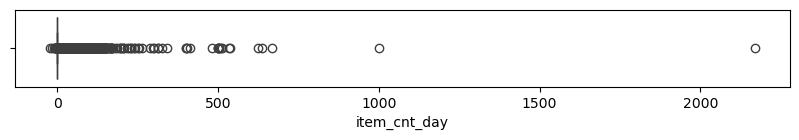

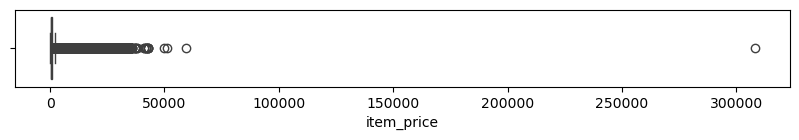

In [10]:
plt.figure(figsize=(10,1))
sns.boxplot(x='item_cnt_day', data=df_train)

plt.figure(figsize=(10,1))
sns.boxplot(x='item_price', data=df_train)

In [11]:
df_train[df_train.item_cnt_day > 500].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name_translated,item_category_id,item_category_name,shop_name,...,holiday,weekend,city,sub_category,rub_amount,krw_amount,year,month,day,year_month
1573253,2014-04-22,15,27,8057,1200.0,502.0,iTunes 1500 ??Ð±.,32,"Payment cards (cinema, music, games)","Moscow shopping center ""Mega white cottage II""",...,0,0,Moscow,Gift Card,602400.0,10843200.0,2014,4,22,2014-04
1708207,2014-06-28,17,25,20949,5.0,501.0,Corporate package T-shirt 1C Interest white (3...,71,"Gifts - bags, albums, rugs d/mouse","Moscow TRK ""Atrium""",...,0,1,Moscow,Gifts,2505.0,45090.0,2014,6,28,2014-06
2048518,2014-10-02,21,12,9242,1500.0,512.0,"Ticket ""Igromir 2014"" (for one day (separately...",8,Tickets (number),Online store of emergency,...,0,0,Online,Tickets,768000.0,13824000.0,2014,10,2,2014-10
2067669,2014-10-09,21,55,19437,899.0,508.0,"Middle Earth: Shadows of Mordor [PC, Digital V...",31,Games PC - number,Digital warehouse 1-online,...,0,0,Online,Games,456692.0,8220456.0,2014,10,9,2014-10
2326930,2015-01-15,24,12,20949,4.0,1000.0,Corporate package T-shirt 1C Interest white (3...,71,"Gifts - bags, albums, rugs d/mouse",Online store of emergency,...,0,0,Online,Gifts,4000.0,72000.0,2015,1,15,2015-01


In [12]:
df_train[df_train.item_price > 40000].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name_translated,item_category_id,item_category_name,shop_name,...,holiday,weekend,city,sub_category,rub_amount,krw_amount,year,month,day,year_month
885138,2013-09-17,8,12,11365,59200.0,1.0,Shipping (EMS),9,Delivery of goods,Online store of emergency,...,0,0,Online,Delivery,59200.0,1065600.0,2013,9,17,2013-09
1006638,2013-10-24,9,12,7238,42000.0,1.0,UserGate Proxy & Firewall 6.X up to 100 sessions,75,Programs - for home and office,Online store of emergency,...,0,0,Online,Programs,42000.0,756000.0,2013,10,24,2013-10
1163158,2013-12-13,11,12,6066,307980.0,1.0,Radmin 3 - 522 people.,75,Programs - for home and office,Online store of emergency,...,0,0,Online,Programs,307980.0,5543640.0,2013,12,13,2013-12
1488135,2014-03-20,14,25,13199,50999.0,1.0,Collectible chess (Lord of the Rings),69,Gifts are souvenirs,"Moscow TRK ""Atrium""",...,0,0,Moscow,Gifts,50999.0,917982.0,2014,3,20,2014-03
2143903,2014-11-20,22,12,14173,40900.0,1.0,1C-Bitrix License: Site Management - Expert,75,Programs - for home and office,Online store of emergency,...,0,0,Online,Programs,40900.0,736200.0,2014,11,20,2014-11


### EDA

In [13]:
year_amount = df_train.groupby('year')['krw_amount'].sum()
year_amount = pd.DataFrame(year_amount).reset_index()

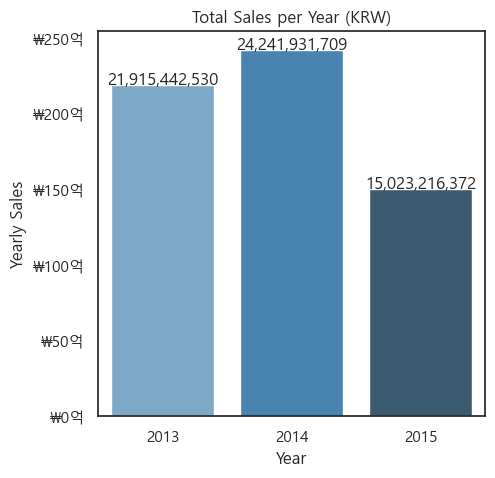

In [14]:
from matplotlib.ticker import FuncFormatter

plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", 
rc={"axes.unicode_minus":False}, style='white')

# 억 원 단위 포맷터
def format_to_100m(x, pos):
    return f'₩{x * 1e-8:.0f}억'  # B for "Billion KRW" (억 단위로 간주)

fig, ax = plt.subplots( figsize=(5,5) )
sns.barplot(data=year_amount, x= 'year', y='krw_amount', palette='Blues_d')

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_to_100m))

for p in ax.patches:
    ax.text(p.get_x() + (p.get_width()/2) ,   # 가로 위치
            p.get_y() + p.get_height(),   # 세로 위치
            f"{p.get_height():,.0f}",   # 값 + 표시방법 소수 둘째자리까지 
            ha = 'center' )   # 좌우정렬 중간으로

plt.xlabel('Year')
plt.ylabel('Yearly Sales')

plt.title('Total Sales per Year (KRW)')
plt.show()

In [15]:
month_amount = df_train.groupby('month')['krw_amount'].sum()
month_amount = pd.DataFrame(month_amount).reset_index()

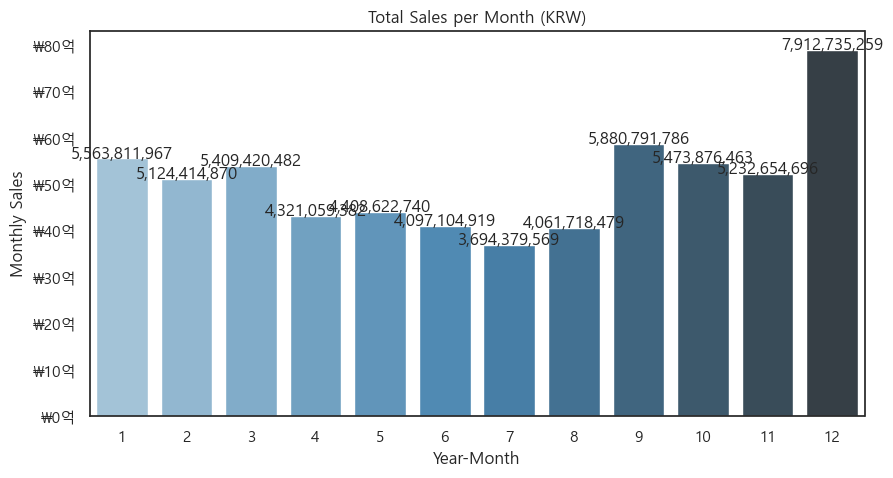

In [16]:
from matplotlib.ticker import FuncFormatter

# 억 원 단위 포맷터
def format_to_100m(x, pos):
    return f'₩{x * 1e-8:.0f}억'  # B for "Billion KRW" (억 단위로 간주)


fig, ax = plt.subplots( figsize=(10,5) )
sns.barplot(data=month_amount, x= 'month', y='krw_amount', palette='Blues_d')

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_to_100m))
for p in ax.patches:
    ax.text(p.get_x() + (p.get_width()/2) ,   # 가로 위치
            p.get_y() + p.get_height(),   # 세로 위치
            f"{p.get_height():,.0f}",   # 값 + 표시방법 소수 둘째자리까지 
            ha = 'center' )   # 좌우정렬 중간으로
plt.xlabel('Year-Month')
plt.ylabel('Monthly Sales')
plt.title('Total Sales per Month (KRW)')
plt.show()

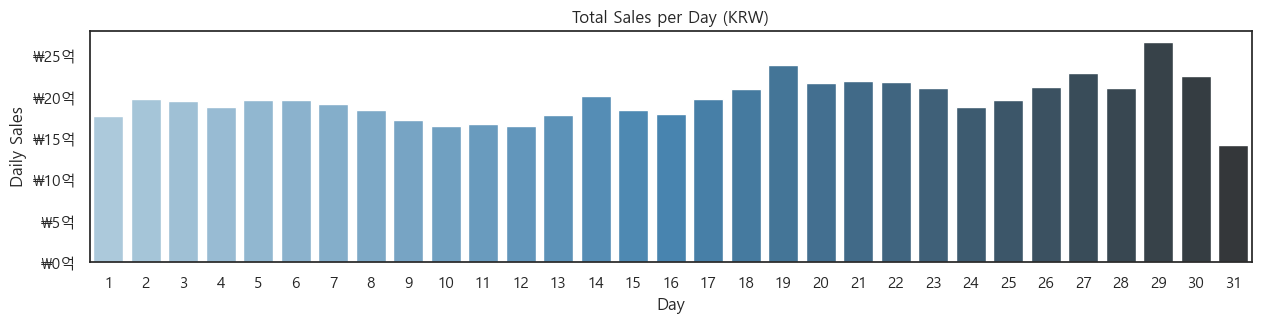

In [17]:
day_amount = df_train.groupby('day')['krw_amount'].sum()
day_amount = pd.DataFrame(day_amount).reset_index()

fig, ax = plt.subplots( figsize=(15,3) )
sns.barplot(data=day_amount, x= 'day', y='krw_amount', palette='Blues_d')

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_to_100m))
plt.xlabel('Day')
plt.ylabel('Daily Sales')    
plt.title('Total Sales per Day (KRW)')
plt.show()

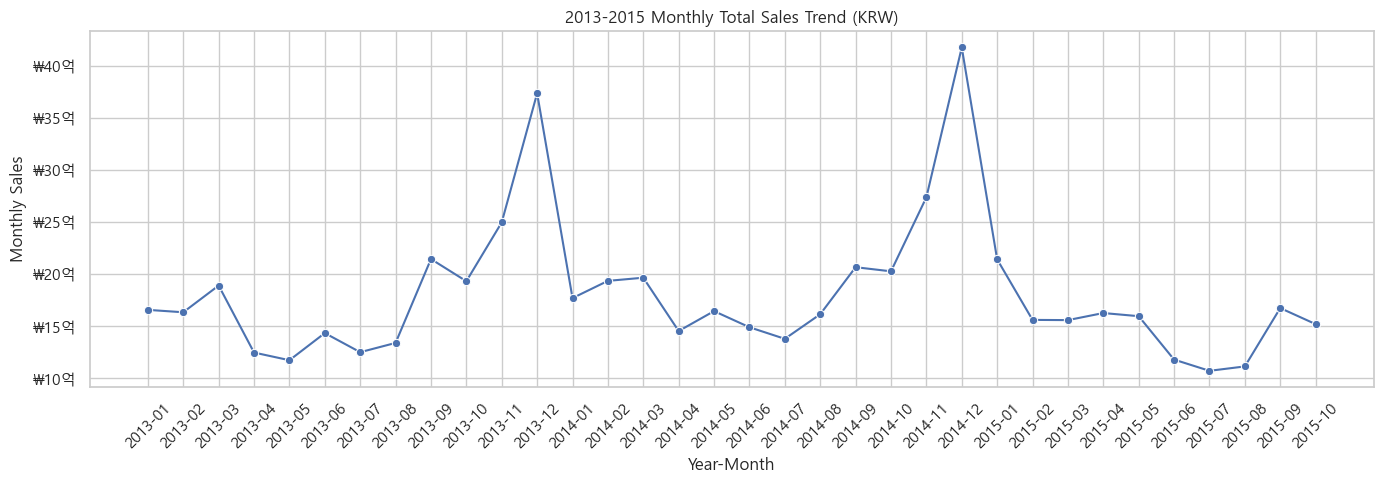

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", 
rc={"axes.unicode_minus":False}, style='whitegrid')

# 월별  평균 매출 계산
monthly_sales = df_train.groupby('year_month')['krw_amount'].sum()
monthly_sales = pd.DataFrame(monthly_sales).reset_index()

plt.figure(figsize=(14, 5))
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_to_100m))
# sns.set_style('whitegrid')
sns.lineplot(data=monthly_sales, x= monthly_sales['year_month'].astype(str), y='krw_amount', palette='Blues_d', marker = 'o')

plt.title('2013-2015 Monthly Total Sales Trend (KRW)')
plt.xlabel('Year-Month')
plt.ylabel('Monthly Sales')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
# 최고 판매량 아이템의 월별 실적 확인 (신상품 출시 영향 및 주요 판매월 확인용)

total_item_sales = (
    df_train.groupby(['item_id', 'item_name_translated'])['krw_amount']
    .sum()
    .reset_index(name='total_sales')
)

# 최고 판매량 아이템 추출
total_top_items = (
    total_item_sales
    .sort_values(['total_sales'], ascending=[False])
    # .groupby('year_month')
    .head(10)
    .reset_index(drop=True)
)

top_item_ids = total_top_items['item_id'].unique()
filtered = df_train[(df_train['item_id'].isin(top_item_ids))]

# 피벗 테이블 생성
pivot = pd.pivot_table(
    filtered,
    index=['item_id', 'item_name_translated'],
    columns='year_month',
    values='krw_amount',
    aggfunc='sum',
    # fill_value=0
)

pivot = pivot.loc[total_top_items['item_id'].values] 


pivot

,year_month,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
item_id,item_name_translated,,,,,,,,,,,,,,,,,,,,,
6675,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1108A/B01),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.132752e+08,7.550675e+07,72563084.64,3.545165e+07,64307799.00,8.041311e+07,11800313.46,7.433676e+06,831348.00,8.888940e+05
3732,"Grand Theft Auto V [PS3, Russian subtitles]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.183110e+08,1.279637e+08,...,8.185638e+06,6.711048e+06,5791462.74,3.905856e+06,4327526.34,4.331007e+06,5299837.74,5.863653e+06,4070996.10,2.814372e+06
13443,?Ð¾Ð¼Ð¿Ð»ÐµÐº? Sony PS4 (500 Gb) Black (CUH-1108A/B01) + Ð¸Ð³?Ð° Grand Theft Auto V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.415349e+07,1.230784e+07,13022118.00,5.272200e+06,1007631.00,5.038200e+05,-503820.00,NaN,NaN,NaN
3734,"Grand Theft Auto V [Xbox 360, Russian subtitles]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.470401e+08,1.191410e+08,...,1.028922e+07,5.435406e+06,5799049.74,6.585011e+06,6333662.34,2.284101e+06,4808469.96,5.604824e+06,2692008.00,3.548556e+06
3733,"Grand Theft Auto V [PS4, Russian subtitles]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.304768e+07,1.466703e+07,11964889.98,9.264132e+06,7652565.00,5.369101e+06,7526843.46,5.474169e+06,5826645.00,4.449959e+06
16787,"Some of us [PS3, Russian version]",NaN,NaN,NaN,NaN,NaN,1.443180e+08,6.263014e+07,33773445.90,1.765946e+07,1.316009e+07,...,4.737210e+06,1.583010e+06,805896.00,4.264920e+05,397074.24,2.878200e+04,453384.00,7.404860e+05,340029.00,7.178580e+05
3731,"Grand Theft Auto V [PC, Russian subtitles]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.557766e+08,6808517.64,2.874848e+07,25531922.88,2.319227e+07,10365331.50,9.279576e+06
13405,"?Ð¾Ð¼Ð¿Ð»ÐµÐº? ""Microsoft Xbox One 500GB (Day One Edition Green Box)"" + ""FIFA 15"" + ""Forza Motorsport 5""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.944170e+07,2.339100e+06,2725956.00,4.307760e+06,3857760.00,1.961271e+06,1403451.00,4.678200e+05,1220328.00,1.083546e+06
17717,Acceptance of funds for 1C-Online,1064322.00,1822086.0,3663305.82,1440666.0,539405.82,3.751380e+05,3.839216e+05,364913.64,4.545898e+05,6.377400e+05,...,2.712917e+07,1.987186e+07,24485418.00,1.892034e+07,11589156.00,9.645336e+06,9377730.00,1.001153e+07,10565802.00,1.086230e+07


In [20]:
# 2013년 최고 판매량 아이템의 월별 실적 확인 (신상품 출시 영향 및 주요 판매월 확인용)

df_train['year'] = df_train['year'].astype(str)

# 2013 만 필터링
yearly = df_train[df_train['year'] == '2013']

yearly_item_sales = (
    yearly.groupby(['item_id', 'item_name_translated'])['krw_amount']
    .sum()
    .reset_index(name='total_sales')
)

# 연간 최고 판매량 아이템 추출
yearly_top_items = (
    yearly_item_sales
    .sort_values(['total_sales'], ascending=[False])
    # .groupby('year_month')
    .head(10)
    .reset_index(drop=True)
)

top_item_ids = yearly_top_items['item_id'].unique()
filtered = df_train[(df_train['year'] == '2013') & (df_train['item_id'].isin(top_item_ids))]

# 피벗 테이블 생성
pivot = pd.pivot_table(
    filtered,
    index=['item_id', 'item_name_translated'],
    columns='year_month',
    values='krw_amount',
    aggfunc='sum',
    # fill_value=0
)

pivot = pivot.loc[yearly_top_items['item_id'].values] 


pivot

,year_month,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12
item_id,item_name_translated,,,,,,,,,,,,
6675,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1108A/B01),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.786951e+08,8.362752e+08
3732,"Grand Theft Auto V [PS3, Russian subtitles]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.183110e+08,1.279637e+08,4.324556e+07,6.171891e+07
3734,"Grand Theft Auto V [Xbox 360, Russian subtitles]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.470401e+08,1.191410e+08,3.688367e+07,5.013045e+07
16787,"Some of us [PS3, Russian version]",NaN,NaN,NaN,NaN,NaN,1.443180e+08,6.263014e+07,33773445.9,1.765946e+07,1.316009e+07,9.152352e+06,1.675375e+07
2808,"Diablo III [PC, Jewel, Russian version]",15233022.00,9579830.4,8661843.0,10147572.0,16129022.4,4.509231e+07,3.347258e+07,13488046.2,3.604298e+07,1.243822e+07,5.587902e+06,8.155825e+06
13490,Set Â«Sony PS3 Super Slim (500 Gb) (CECH-4008C)Â» + game Â«Holiday Sports 2Â» + Camera PS Eye + Co,26786046.60,21522362.4,15854916.6,13937139.0,11448659.7,1.529277e+07,1.286703e+07,7426944.0,2.572020e+06,5.036400e+05,NaN,5.822388e+05
7942,Xbox 360 250 ?? Kinect bundle Sports 2+Forza Horizon (5DX-00008),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.053467e+07,3.207139e+07,7.653818e+07
7938,Xbox 360 250 ?? + Kinect bundle Ð¼Ð°?Ð¾Ð²Ð°?+Dance Central 2+Kinect Sports,31081194.00,34014535.2,20912061.6,7873074.0,2833371.0,2.825208e+06,5.267790e+06,5468211.0,2.068560e+06,9.024966e+05,NaN,1.099080e+06
13484,?Ð¾Ð¼Ð¿Ð»ÐµÐº? Â«Sony PS3 Super Slim (500 Gb) (CECH-4008C)Â» + Ð¸Ð³?Ð° Â«Gran Turismo 5 Academy EditionÂ» + Ð¸Ð³?Ð°,23070388.14,10802052.0,12695839.2,8073441.0,7284582.0,1.044126e+07,8.498700e+06,11133360.0,1.178739e+07,4.191894e+06,6.564600e+05,1.791234e+06


In [21]:
# 2014년 최고 판매량 아이템의 월별 실적 확인 (신상품 출시 영향 및 주요 판매월 확인용)

df_train['year'] = df_train['year'].astype(str)

# 2014 만 필터링
yearly = df_train[df_train['year'] == '2014']

yearly_item_sales = (
    yearly.groupby(['item_id', 'item_name_translated'])['krw_amount']
    .sum()
    .reset_index(name='total_sales')
)

# 연간 최고 판매량 아이템 추출
yearly_top_items = (
    yearly_item_sales
    .sort_values(['total_sales'], ascending=[False])
    # .groupby('year_month')
    .head(10)
    .reset_index(drop=True)
)

top_item_ids = yearly_top_items['item_id'].unique()
filtered = df_train[(df_train['year'] == '2014') & (df_train['item_id'].isin(top_item_ids))]

# 피벗 테이블 생성
pivot = pd.pivot_table(
    filtered,
    index=['item_id', 'item_name_translated'],
    columns='year_month',
    values='krw_amount',
    aggfunc='sum',
    # fill_value=0
)

pivot = pivot.loc[yearly_top_items['item_id'].values] 


pivot

,year_month,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12
item_id,item_name_translated,,,,,,,,,,,,
6675,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1108A/B01),1.314063e+08,4.640710e+08,2.492137e+08,1.525261e+08,1.410142e+08,163732968.0,1.543550e+08,1.946485e+08,1.413265e+08,1.092927e+08,9.775142e+07,7.226620e+07
13443,?Ð¾Ð¼Ð¿Ð»ÐµÐº? Sony PS4 (500 Gb) Black (CUH-1108A/B01) + Ð¸Ð³?Ð° Grand Theft Auto V,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.654506e+07,4.356541e+08
3733,"Grand Theft Auto V [PS4, Russian subtitles]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.184939e+08,8.764267e+07
13405,"?Ð¾Ð¼Ð¿Ð»ÐµÐº? ""Microsoft Xbox One 500GB (Day One Edition Green Box)"" + ""FIFA 15"" + ""Forza Motorsport 5""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.776101e+07,4.014861e+07,2.721470e+07,1.423256e+08
3928,"InFAMOUS: The second son [PS4, Russian version]",NaN,NaN,8.957799e+07,3.520218e+07,1.901719e+07,14890122.9,1.708470e+07,3.585911e+07,6.994062e+06,7.618687e+06,5.946944e+06,1.070065e+07
16790,"One of us. Updated version [PS4, Russian version]",NaN,NaN,NaN,NaN,NaN,NaN,7.336125e+07,7.096652e+07,1.812672e+07,1.290249e+07,1.104120e+07,2.049241e+07
7807,"Watch_Dogs. Special Edition [PS4, Russian version]",NaN,NaN,NaN,NaN,1.173674e+08,48162117.6,1.188142e+07,7.290972e+06,4.729158e+06,3.472550e+06,2.310426e+06,6.478502e+06
3732,"Grand Theft Auto V [PS3, Russian subtitles]",4.136263e+07,2.168951e+07,1.745851e+07,1.315326e+07,1.485998e+07,14428598.4,1.070724e+07,1.106064e+07,8.866296e+06,7.699986e+06,7.114949e+06,1.418138e+07
5672,PS4: Game controller wireless black (Dualshock 4 Cont Anthracite Black: CUH-ZCT1: SCEE),1.612170e+07,2.763054e+07,2.003260e+07,1.174429e+07,1.347264e+07,15118200.0,1.774899e+07,1.053014e+07,9.564552e+06,7.300219e+06,9.105444e+06,1.906617e+07


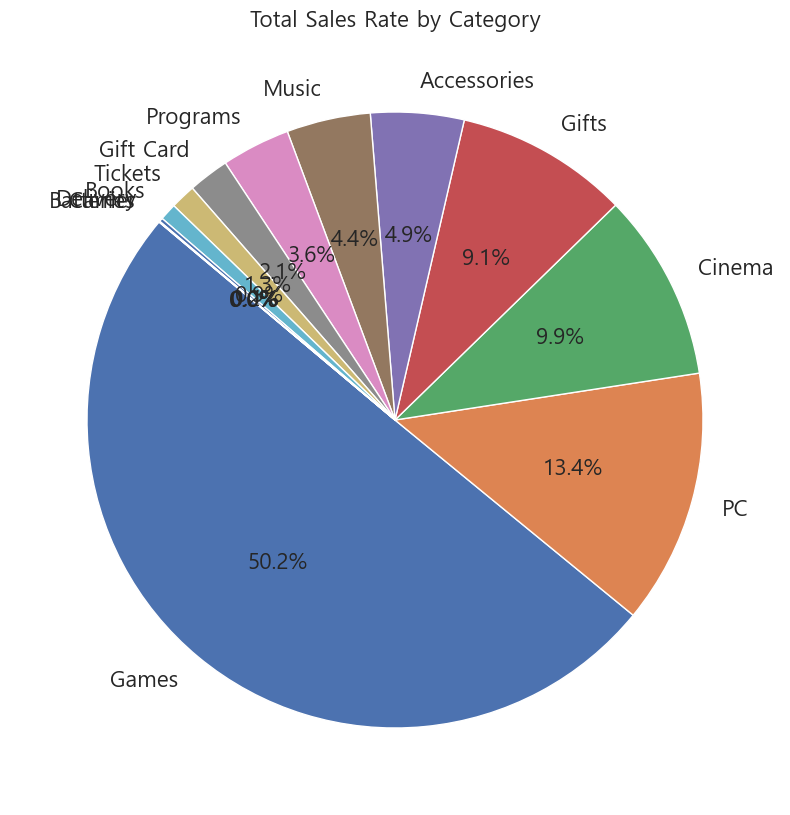

In [22]:
import matplotlib.pyplot as plt

# 카테고리별 총 판매량 합계 계산
category_sales = df_train.groupby('sub_category')['krw_amount'].sum().sort_values(ascending=False)

# colors = sns.color_palette('Blues_r') 

# 파이차트 그리기
plt.figure(figsize=(10, 10))
plt.pie(
    category_sales,
    labels=category_sales.index,
    autopct='%1.1f%%',
    startangle=140,
    # colors = colors,
    textprops={'fontsize': 16}
)
plt.title('Total Sales Rate by Category', fontsize=16)
plt.show()

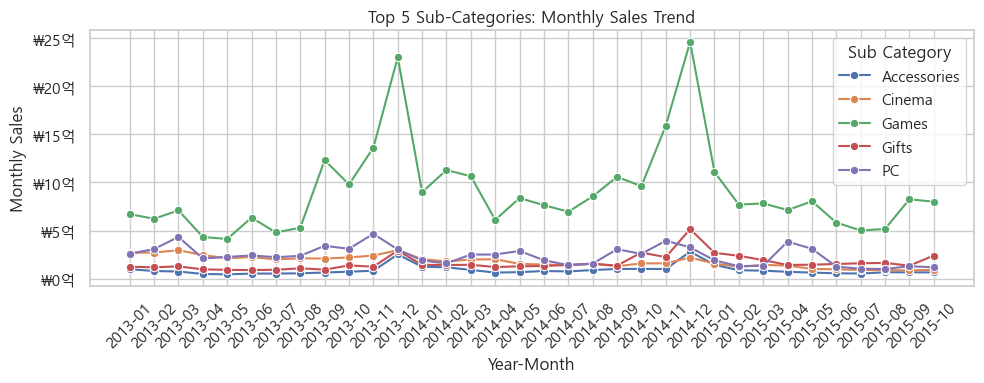

In [23]:
# 연-월 컬럼 추가 (문자열로 변환)
df_train['year_month'] = df_train['date'].dt.to_period('M').astype(str)

category_trend = (
    df_train
    .groupby(['year_month', 'sub_category'])['krw_amount']
    .sum()
    .reset_index(name='total_sales')
)

plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", 
rc={"axes.unicode_minus":False}, style='whitegrid')

# 시각화
plt.figure(figsize=(10, 4))
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_to_100m))
# sns.set_style('whitegrid')

# 상위 5개 카테고리만 필터링해서 예시
top_categories = (
    category_trend.groupby('sub_category')['total_sales'].sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)
filtered = category_trend[category_trend['sub_category'].isin(top_categories)]

# 라인플롯
sns.lineplot(
    data=filtered,
    x='year_month',
    y='total_sales',
    hue='sub_category',
    marker='o'
)

plt.title('Top 5 Sub-Categories: Monthly Sales Trend')
plt.xticks(rotation=45)
plt.xlabel('Year-Month')
plt.ylabel('Monthly Sales')
plt.legend(title='Sub Category')
plt.tight_layout()
plt.show()

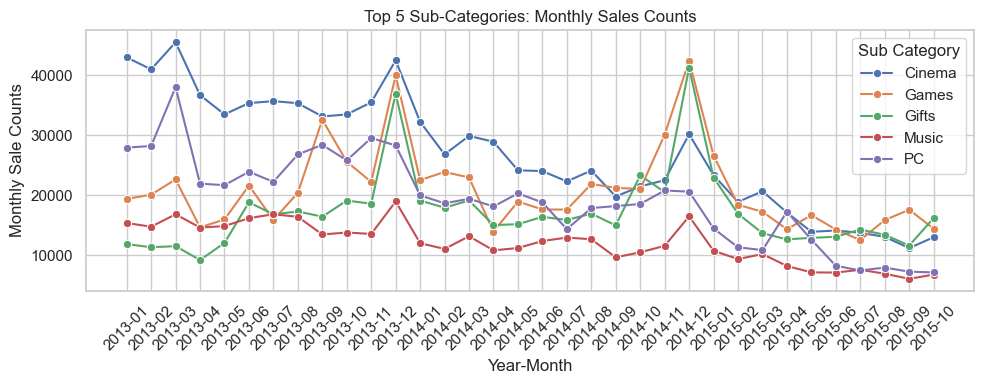

In [24]:
# 연-월 컬럼 추가 (문자열로 변환)
df_train['year_month'] = df_train['date'].dt.to_period('M').astype(str)

category_trend = (
    df_train
    .groupby(['year_month', 'sub_category'])['item_cnt_day']
    .sum()
    .reset_index(name='total_sales')
)


# 시각화
plt.figure(figsize=(10, 4))
sns.set_style('whitegrid')

# 상위 5개 카테고리만 필터링해서 예시
top_categories = (
    category_trend.groupby('sub_category')['total_sales'].sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)
filtered = category_trend[category_trend['sub_category'].isin(top_categories)]

# 라인플롯
sns.lineplot(
    data=filtered,
    x='year_month',
    y='total_sales',
    hue='sub_category',
    marker='o'
)

plt.title('Top 5 Sub-Categories: Monthly Sales Counts')
plt.xticks(rotation=45)
plt.xlabel('Year-Month')
plt.ylabel('Monthly Sale Counts')
plt.legend(title='Sub Category')
plt.tight_layout()
plt.show()

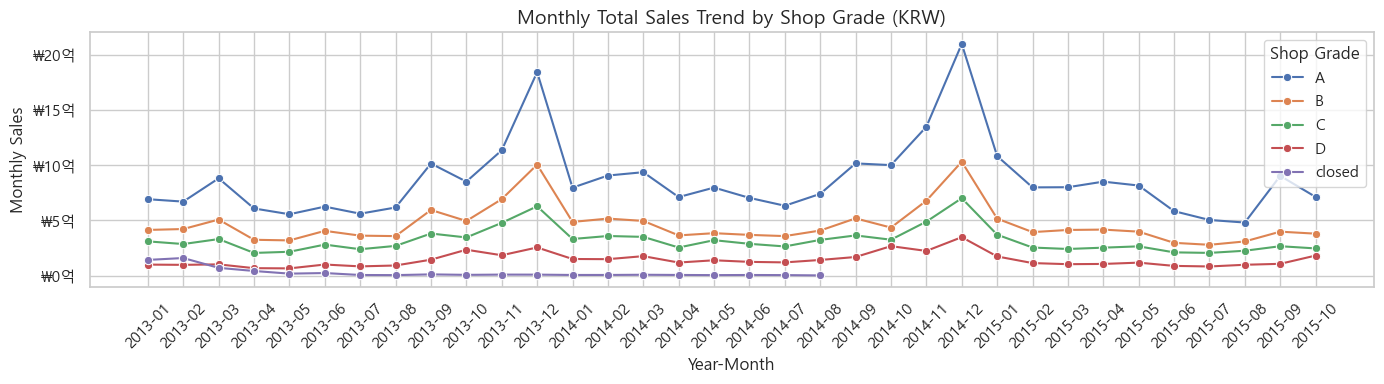

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Convert Period to Timestamp if necessary
if df_train['year_month'].dtype.name == 'period[M]':
    df_train['year_month'] = df_train['year_month'].dt.to_timestamp()

# Grouped monthly total sales
monthly_avg_sales = (
    df_train.groupby(['shop_grade', 'year_month'])['krw_amount']
    .sum()
    .reset_index()
)

plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", 
rc={"axes.unicode_minus":False}, style='whitegrid')

# 억 원 단위 포맷터
def format_to_100m(x, pos):
    return f'₩{x * 1e-8:.0f}억'  # B for "Billion KRW" (억 단위로 간주)

# Visualization
plt.figure(figsize=(14, 4))
# sns.set_style("whitegrid")
sns.lineplot(data=monthly_avg_sales, x='year_month', y='krw_amount', hue='shop_grade', marker='o')

plt.title('Monthly Total Sales Trend by Shop Grade (KRW)', fontsize=14)
plt.xlabel('Year-Month')
plt.ylabel('Monthly Sales')
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_to_100m))
plt.xticks(rotation=45)
plt.legend(title='Shop Grade', loc=1)
plt.tight_layout()
plt.show()

In [26]:
# 매장별 총 판매량과 등급, 이름 포함
shop_sales_ranked = (
    df_train
    .groupby(['shop_id', 'shop_name', 'shop_grade'])['krw_amount']
    .sum()
    .reset_index(name='total_sales')
    .sort_values(by='total_sales', ascending=False)
    .reset_index(drop=True)
)

# 순위 컬럼 추가 (1위부터)
shop_sales_ranked['rank'] = shop_sales_ranked.index + 1

shop_sales_ranked.head()

,shop_id,shop_name,shop_grade,total_sales,rank
0,31,"Moscow shopping center ""Semenovsky""",A,4.233906e+09,1
1,25,"Moscow TRK ""Atrium""",A,3.896632e+09,2
2,28,"Moscow shopping center ""Mega Teply Stan"" II",A,2.875434e+09,3
3,42,"SPb TK ""Nevsky Center""",A,2.734498e+09,4
4,54,"Khimki shopping center ""mega""",A,2.554911e+09,5


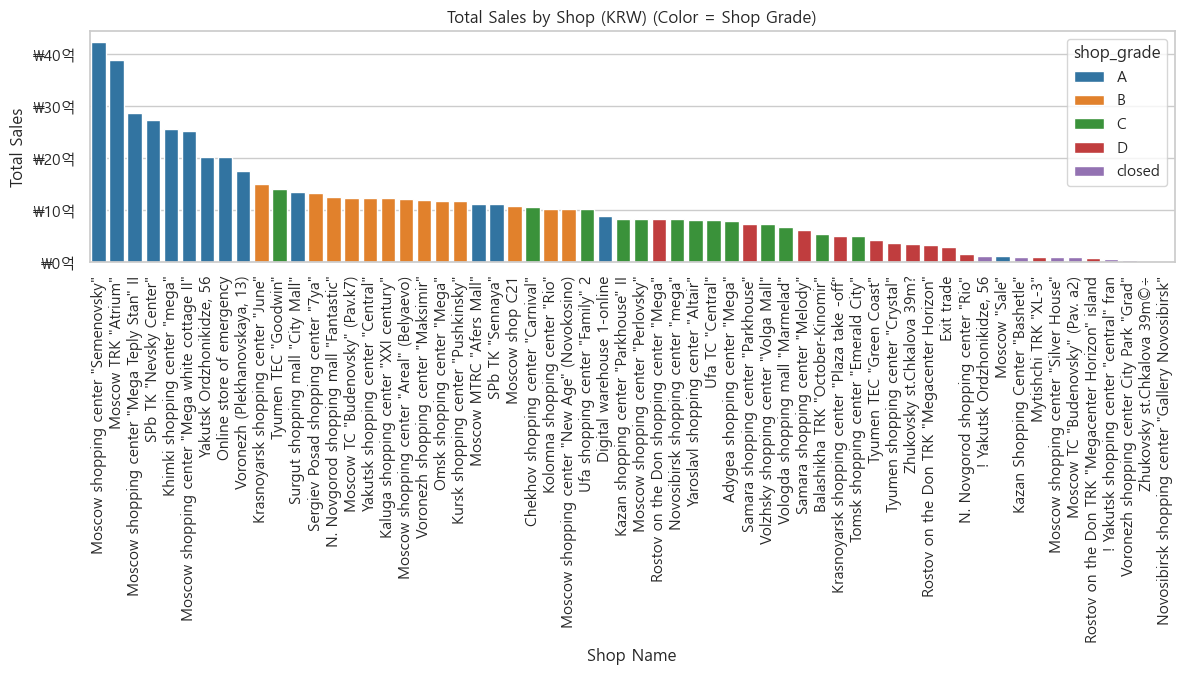

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", 
rc={"axes.unicode_minus":False}, style='whitegrid')

# 억 원 단위 포맷터
def format_to_100m(x, pos):
    return f'₩{x * 1e-8:.0f}억'  # B for "Billion KRW" (억 단위로 간주)

plt.figure(figsize=(14, 3))
# sns.set_style('whitegrid')

# 팔레트 지정 (등급별 색상)
palette = {'A': '#1f77b4', 'B': '#ff7f0e', 'C': '#2ca02c', 'D': '#d62728', 'closed': '#9467bd'}

# 막대그래프 (x: shop_name, y: 총 판매량, hue: 등급)
barplot = sns.barplot(
    data=shop_sales_ranked,
    x='shop_name',
    y='total_sales',
    hue='shop_grade',
    dodge=False,
    palette=palette
)
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_to_100m))
plt.xticks(rotation=90)

plt.title('Total Sales by Shop (KRW) (Color = Shop Grade)')
plt.xlabel('Shop Name')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

### 2015년 10월 매출 분석

In [28]:
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name_translated,item_category_id,item_category_name,shop_name,...,holiday,weekend,city,sub_category,rub_amount,krw_amount,year,month,day,year_month
0,2013-01-02,0,59,22154,999.00,1.0,SCENE 2012 (BD),37,Cinema - Blu -Ray,"Yaroslavl shopping center ""Altair""",...,1,0,Yaroslavl,Cinema,999.00,17982.0,2013,1,2,2013-01
1,2013-01-03,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Music - vinyl,"Moscow TRK ""Atrium""",...,1,0,Moscow,Music,899.00,16182.0,2013,1,3,2013-01
2,2013-01-05,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Music - vinyl,"Moscow TRK ""Atrium""",...,0,1,Moscow,Music,-899.00,-16182.0,2013,1,5,2013-01
3,2013-01-06,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Music - vinyl,"Moscow TRK ""Atrium""",...,0,1,Moscow,Music,1709.05,30762.9,2013,1,6,2013-01
4,2013-01-15,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Ð¤Ð¸?Ð¼.),56,Music - CD of corporate production,"Moscow TRK ""Atrium""",...,0,0,Moscow,Music,1099.00,19782.0,2013,1,15,2013-01


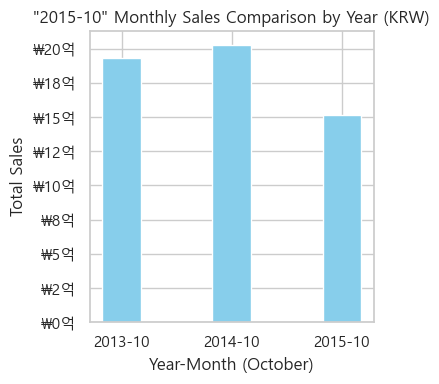

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# 비교할 연도 10월 데이터 필터링
compare_years = ['2013-10', '2014-10', '2015-10']
df_train['year_month'] = df_train['date'].dt.to_period('M')
annual_sales = df_train[df_train['year_month'].astype(str).isin(compare_years)]

# 연도별 매출 합계 계산
annual_summary = annual_sales.groupby('year_month')['krw_amount'].sum().sort_index()
annual_summary_reset = pd.DataFrame(annual_summary).reset_index()
index = range(len(annual_summary_reset))

plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", 
rc={"axes.unicode_minus":False}, style='whitegrid')

# 스타일 설정
# sns.set_style('whitegrid')
plt.figure(figsize=(4,4))

# 데이터 재정렬 및 인덱스 생성
bar_width = 0.35
index = range(len(annual_summary_reset))
# 억 원 단위 포맷터
def format_to_100m(x, pos):
    return f'₩{x * 1e-8:.0f}억'  # B for "Billion KRW" (억 단위로 간주)

# 한화 매출 막대
plt.bar(index, annual_summary_reset['krw_amount'], bar_width, label='KRW Amount', color='skyblue')

# x축 라벨 설정 (2013-10, 2014-10, 2015-10)
plt.xticks(index, annual_summary_reset['year_month'])
plt.xlabel('Year-Month (October)')
plt.ylabel('Total Sales')
plt.title('"2015-10" Monthly Sales Comparison by Year (KRW)')
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_to_100m))
# plt.legend()

plt.tight_layout()
plt.show()

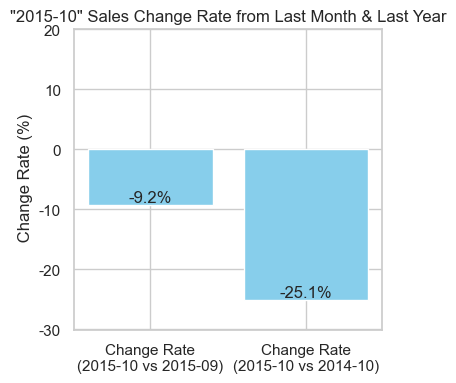

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# 각 비교별 % 변화율 계산 (루블, 한화 합계 기준)
# rub_amount와 krw_amount 합친 총 매출 기준으로 할 수도 있지만, 여기서는 krw_amount 기준으로 예시 작성

compare_months = ['2015-10', '2015-09', '2014-10']
monthly_sales = df_train[df_train['year_month'].astype(str).isin(compare_months)]
monthly_summary = monthly_sales.groupby('year_month')[['rub_amount', 'krw_amount']].sum().sort_index()
month_rate = (monthly_summary.loc['2015-10', 'krw_amount'] / monthly_summary.loc['2015-09', 'krw_amount'] - 1) * 100
year_month_rate = (monthly_summary.loc['2015-10', 'krw_amount'] / monthly_summary.loc['2014-10', 'krw_amount'] - 1) * 100

# 데이터 프레임 생성
rates = pd.Series([ month_rate, year_month_rate],
                  index=['Change Rate\n(2015-10 vs 2015-09)', 'Change Rate\n(2015-10 vs 2014-10)'])

plt.figure(figsize=(4,4))
bars = plt.bar(rates.index, rates.values, color='skyblue')

plt.ylabel(' Change Rate (%)')
plt.title('"2015-10" Sales Change Rate from Last Month & Last Year') # Rub이나 KRW이나 비율은 같음
plt.ylim(min(rates.values.min() - 5, -20), max(rates.values.max() + 5, 20))

# 막대 위에 값 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}%',
             ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

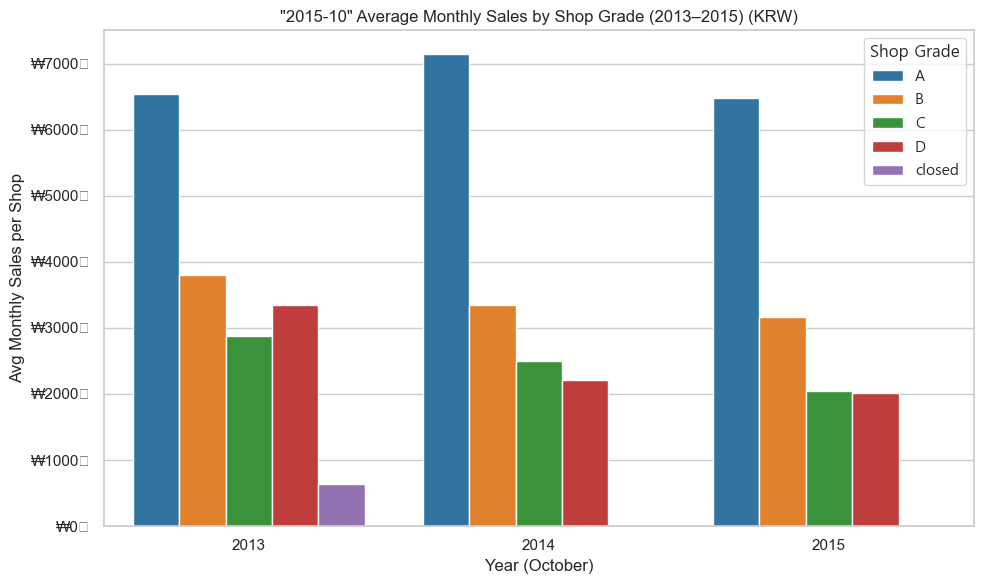

📊 2015년 10월 평균 *월간 판매량* 및 전년 동월 대비 증감률

[등급 A]
- 평균 월간 판매량 (2015년 10월): 64,719,294
- 2014년 대비 증감률: -9.4%
- 2013년 대비 증감률: -1.1%

[등급 B]
- 평균 월간 판매량 (2015년 10월): 31,615,291
- 2014년 대비 증감률: -5.4%
- 2013년 대비 증감률: -16.9%

[등급 C]
- 평균 월간 판매량 (2015년 10월): 20,479,842
- 2014년 대비 증감률: -18.0%
- 2013년 대비 증감률: -28.8%

[등급 D]
- 평균 월간 판매량 (2015년 10월): 20,112,689
- 2014년 대비 증감률: -9.4%
- 2013년 대비 증감률: -39.8%

[등급 closed]
- 평균 월간 판매량 (2015년 10월): nan
- 2014년 대비 증감률: nan%
- 2013년 대비 증감률: nan%



In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 날짜 처리
df_train['date'] = pd.to_datetime(df_train['date'])
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month

# 2. 10월만 필터링
october = df_train[df_train['month'] == 10]

# 3. 매장별 10월 월간 판매량 계산 (item_cnt_day 합산)
monthly_sales = (
    october
    .groupby(['year', 'shop_id', 'shop_grade'])['krw_amount']
    .sum()
    .reset_index(name='monthly_sales')  # 한 매장의 10월 총 판매량
)

# 4. 연도별, 등급별 평균 매장당 월간 판매량
october_grouped = (
    monthly_sales
    .groupby(['year', 'shop_grade'])['monthly_sales']
    .mean()
    .reset_index(name='avg_sales')
)

# 5. 피벗하여 증감률 계산
oct_pivot = october_grouped.pivot(index='shop_grade', columns='year', values='avg_sales').reset_index()
oct_pivot['2015_vs_2013'] = ((oct_pivot[2015] - oct_pivot[2013]) / oct_pivot[2013] * 100).round(1)
oct_pivot['2015_vs_2014'] = ((oct_pivot[2015] - oct_pivot[2014]) / oct_pivot[2014] * 100).round(1)

# 6. 시각화용 long-form 데이터 생성
plot_df = pd.melt(
    oct_pivot,
    id_vars='shop_grade',
    value_vars=[2013, 2014, 2015],
    var_name='year',
    value_name='avg_sales'
)

# 7. 등급 순서와 색상 정의
grade_order = ['A', 'B', 'C', 'D', 'closed']
palette = {'A': '#1f77b4', 'B': '#ff7f0e', 'C': '#2ca02c', 'D': '#d62728', 'closed': '#9467bd'}

# 8. 시각화
plt.figure(figsize=(10, 6))
# sns.set_style('whitegrid')
sns.barplot(
    data=plot_df,
    x='year',
    y='avg_sales',
    hue='shop_grade',
    palette=palette,
    hue_order=grade_order
)

# 천만원 원 단위 포맷터
def format_to_1k(x, pos):
    return f'₩{x * 1e-4:.0f}만'  # M for 만원 단위로 간주

plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", 
rc={"axes.unicode_minus":False}, style='whitegrid')

plt.title('"2015-10" Average Monthly Sales by Shop Grade (2013–2015) (KRW)')
plt.ylabel('Avg Monthly Sales per Shop')
plt.xlabel('Year (October)')
plt.legend(title='Shop Grade')
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_to_1k))
plt.tight_layout()
plt.show()

# 9. 콘솔 출력
print("📊 2015년 10월 평균 *월간 판매량* 및 전년 동월 대비 증감률\n")
for i, row in oct_pivot.iterrows():
    grade = row['shop_grade']
    sales_2015 = row[2015]
    change_13 = row['2015_vs_2013']
    change_14 = row['2015_vs_2014']

    print(f"[등급 {grade}]")
    print(f"- 평균 월간 판매량 (2015년 10월): {sales_2015:,.0f}")
    print(f"- 2014년 대비 증감률: {'+' if change_14 >= 0 else ''}{change_14}%")
    print(f"- 2013년 대비 증감률: {'+' if change_13 >= 0 else ''}{change_13}%")
    print()


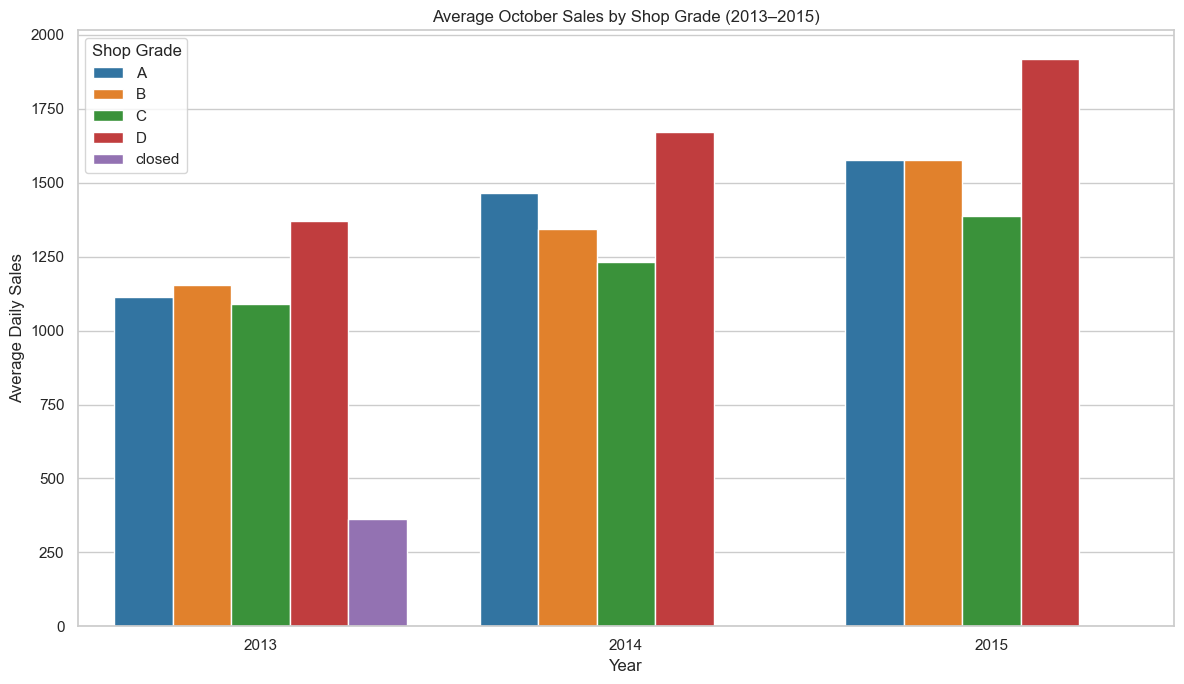

📊 2015년 10월 평균 매출액 및 전년 동월 대비 증감률

[등급 A]
- 평균 매출액 (2015년 10월): 1,576.48
- 2013년 대비 증감률: +41.4%
- 2014년 대비 증감률: +7.6%

[등급 B]
- 평균 매출액 (2015년 10월): 1,578.55
- 2013년 대비 증감률: +36.7%
- 2014년 대비 증감률: +17.3%

[등급 C]
- 평균 매출액 (2015년 10월): 1,388.23
- 2013년 대비 증감률: +27.2%
- 2014년 대비 증감률: +12.7%

[등급 D]
- 평균 매출액 (2015년 10월): 1,919.52
- 2013년 대비 증감률: +40.1%
- 2014년 대비 증감률: +14.9%

[등급 closed]
- 평균 매출액 (2015년 10월): nan
- 2013년 대비 증감률: nan%
- 2014년 대비 증감률: nan%



In [32]:
# rub 매출 분석 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 2. 날짜 처리
df_train['date'] = pd.to_datetime(df_train['date'])
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month

# 3. 10월 데이터만 필터링
october = df_train[df_train['month'] == 10]

# 4. 연도별, 등급별 평균 매출액 집계
october_grouped = (
    october
    .groupby(['year', 'shop_grade'])['rub_amount']
    .mean()
    .reset_index(name='avg_sales')
)

# 5. 시각화용 등급 순서 및 팔레트 정의
grade_order = ['A', 'B', 'C', 'D', 'closed']
palette = {'A': '#1f77b4', 'B': '#ff7f0e', 'C': '#2ca02c', 'D': '#d62728', 'closed': '#9467bd'}

# 6. 막대그래프 그리기
plt.figure(figsize=(12, 7))
sns.set_style('whitegrid')

sns.barplot(
    data=october_grouped,
    x='year',
    y='avg_sales',
    hue='shop_grade',
    palette=palette,
    hue_order=grade_order
)

plt.title('Average October Sales by Shop Grade (2013–2015)')
plt.xlabel('Year')
plt.ylabel('Average Daily Sales')
plt.legend(title='Shop Grade')
plt.tight_layout()
plt.show()

# 3. 피벗 후 증감률 계산
oct_pivot = october_grouped.pivot(index='shop_grade', columns='year', values='avg_sales').reset_index()
oct_pivot['2015_vs_2013'] = ((oct_pivot[2015] - oct_pivot[2013]) / oct_pivot[2013] * 100).round(1)
oct_pivot['2015_vs_2014'] = ((oct_pivot[2015] - oct_pivot[2014]) / oct_pivot[2014] * 100).round(1)

# 4. 출력
print("📊 2015년 10월 평균 매출액 및 전년 동월 대비 증감률\n")
for i, row in oct_pivot.iterrows():
    grade = row['shop_grade']
    sales_2015 = row[2015]
    change_13 = row['2015_vs_2013']
    change_14 = row['2015_vs_2014']

    print(f"[등급 {grade}]")
    print(f"- 평균 매출액 (2015년 10월): {sales_2015:,.2f}")
    print(f"- 2013년 대비 증감률: {'+' if change_13 >= 0 else ''}{change_13}%")
    print(f"- 2014년 대비 증감률: {'+' if change_14 >= 0 else ''}{change_14}%")
    print()

In [33]:
# 1. 날짜 처리
df_train['year_month'] = df_train['date'].dt.to_period('M').astype(str)

# 2. 10월만 필터링
october = df_train[df_train['year_month'] == '2015-10']

# 3. 매장별 10월 월간 판매량 계산 (item_cnt_day 합산)
grade_category_monthly_sales = (
    october
    .groupby(['sub_category', 'shop_grade'])['krw_amount']
    .sum()
    .reset_index(name='monthly_sales')  # 한 매장의 10월 총 판매량
)

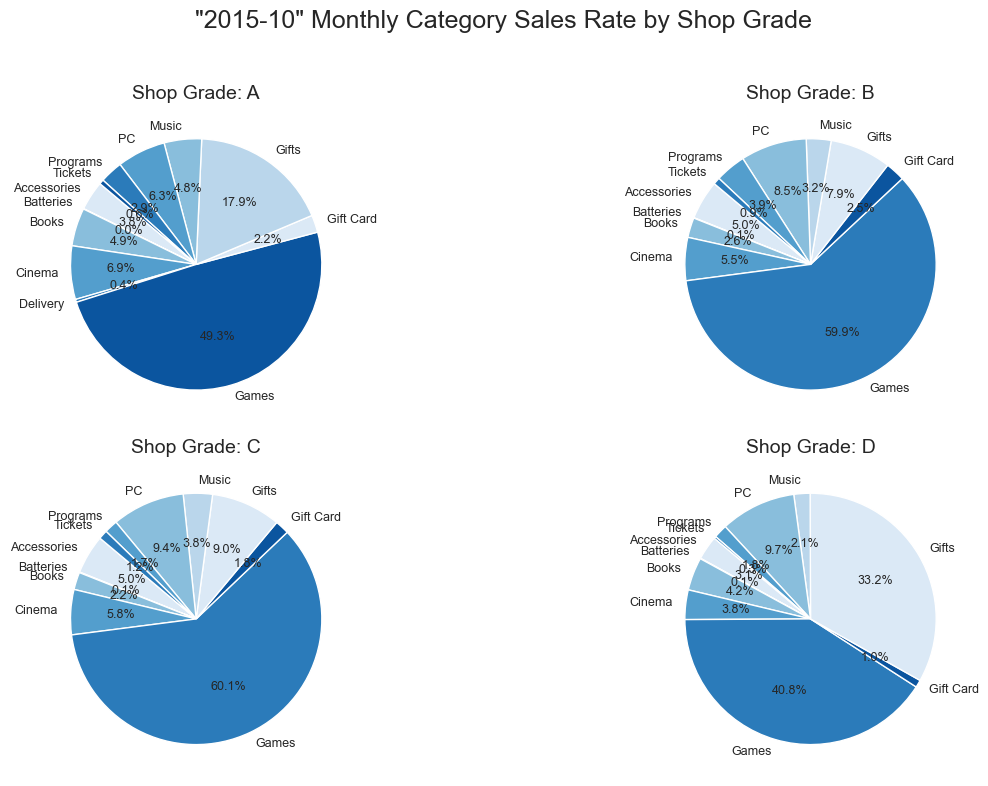

In [34]:
import math

grades = sorted(grade_category_monthly_sales['shop_grade'].unique())
n_grades = len(grades)

# 행, 열 개수 계산 (예: 최대 2열, 행은 필요한 만큼)
n_cols = 2
n_rows = math.ceil(n_grades / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(7 * n_cols, 4 * n_rows))
axes = axes.flatten()  # 1차원 배열로 변환

# colors = sns.color_palette('BuPu_r',len(grade_category_monthly_sales['sub_category'])) ## 라벨의 개수 만큼 색상 리스트 생성 
colors = sns.color_palette('Blues') 

for i, grade in enumerate(grades):
    data = grade_category_monthly_sales[grade_category_monthly_sales['shop_grade'] == grade]
    data = data[data['monthly_sales'] > 0]
    sales = data['monthly_sales']
    categories = data['sub_category']

    axes[i].pie(
        sales,
        labels=categories,
        autopct='%1.1f%%',
        startangle=140,
        textprops={'fontsize': 9},
        colors = colors  
    )
    axes[i].set_title(f'Shop Grade: {grade}', fontsize=14)

# 남는 subplot은 삭제
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('"2015-10" Monthly Category Sales Rate by Shop Grade', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [35]:
# 1. 날짜 처리
df_train['year_month'] = df_train['date'].dt.to_period('M').astype(str)

# 2. 10월만 필터링
october = df_train[df_train['year_month'] == '2015-10']

# 3. 매장별 10월 월간 판매량 계산 (item_cnt_day 합산)
grade_category_monthly_sales = (
    october
    .groupby(['sub_category', 'shop_grade'])['item_name_translated']
    .nunique()
    .reset_index(name='monthly_sales')
)

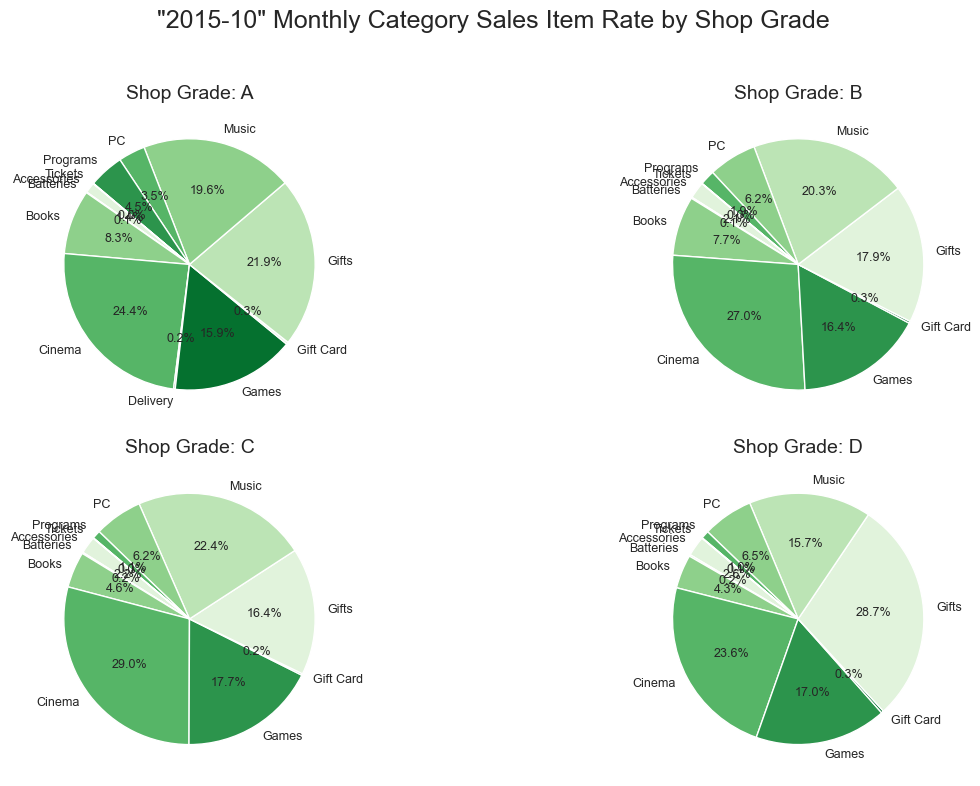

In [36]:
import math

grades = sorted(grade_category_monthly_sales['shop_grade'].unique())
n_grades = len(grades)

# 행, 열 개수 계산 (예: 최대 2열, 행은 필요한 만큼)
n_cols = 2
n_rows = math.ceil(n_grades / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(7 * n_cols, 4 * n_rows))
axes = axes.flatten()  # 1차원 배열로 변환

# colors = sns.color_palette('BuPu_r',len(grade_category_monthly_sales['sub_category'])) ## 라벨의 개수 만큼 색상 리스트 생성 
colors = sns.color_palette('Greens') ## 라벨의 개수 만큼 색상 리스트 생성 

for i, grade in enumerate(grades):
    data = grade_category_monthly_sales[grade_category_monthly_sales['shop_grade'] == grade]
    data = data[data['monthly_sales'] > 0]
    sales = data['monthly_sales']
    categories = data['sub_category']

    axes[i].pie(
        sales,
        labels=categories,
        autopct='%1.1f%%',
        startangle=140,
        textprops={'fontsize': 9},
        colors = colors  
    )
    axes[i].set_title(f'Shop Grade: {grade}', fontsize=14)

# 남는 subplot은 삭제
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('"2015-10" Monthly Category Sales Item Rate by Shop Grade', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


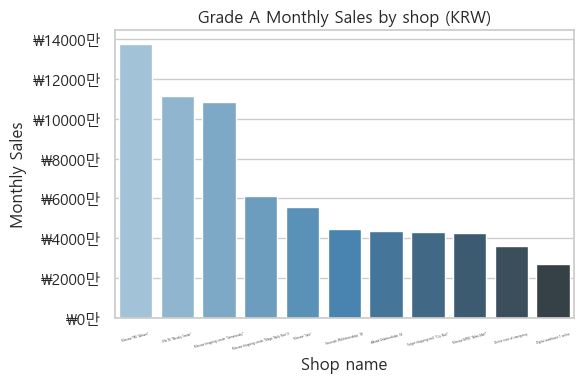

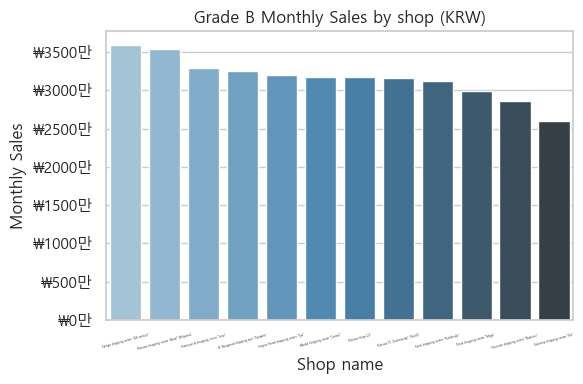

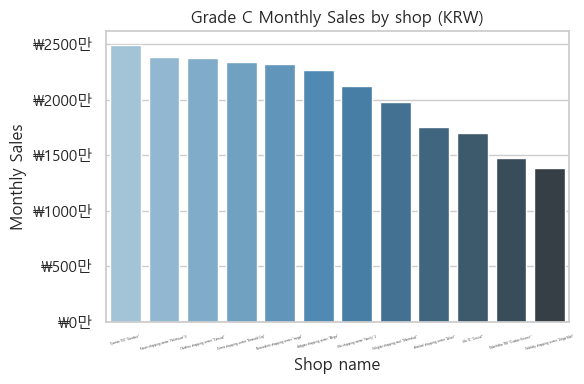

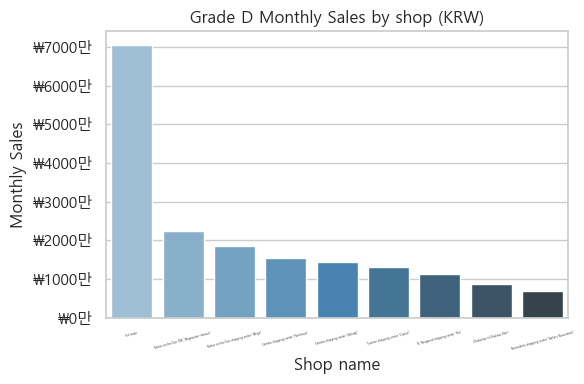

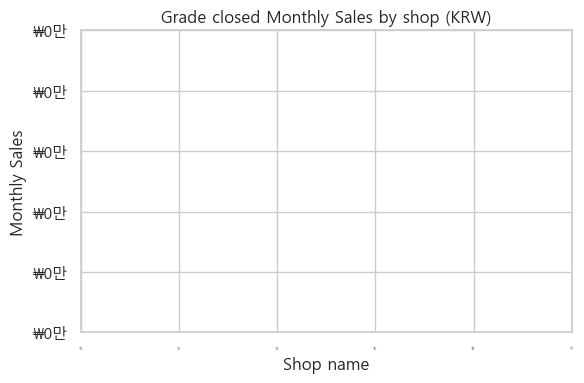

In [37]:
# 천만원 원 단위 포맷터
def format_to_1k(x, pos):
    return f'₩{x * 1e-4:.0f}만'  # M for 만원 단위로 간주

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. 날짜 처리
df_train['year_month'] = df_train['date'].dt.to_period('M').astype(str)

# 2. 10월만 필터링
october = df_train[df_train['year_month'] == '2015-10']

# 3. 매장별 10월 월간 판매량 계산 (item_cnt_day 합산)
grade_monthly_sales = (
    october
    .groupby(['shop_name', 'shop_grade'])['krw_amount']
    .sum()
    .reset_index(name='monthly_sales')
)

plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", 
rc={"axes.unicode_minus":False}, style='whitegrid')
# sns.set_style('whitegrid')

grades = np.sort(df_train['shop_grade'].unique())  # 오름차순 정렬 (A, B, C, D...)

for g in grades:
    # 해당 grade의 데이터 필터링
    data = grade_monthly_sales[grade_monthly_sales['shop_grade'] == g]

    # 매장별 총 판매량 계산
    store_sales = data.groupby('shop_name')['monthly_sales'].sum().reset_index(name='monthly_sales')

    # 판매량 기준 내림차순 정렬
    store_sales = store_sales.sort_values(by='monthly_sales', ascending=False)

    plt.figure(figsize=(6,4))
    sns.barplot(data=store_sales, x='shop_name', y='monthly_sales', palette='Blues_d')
    plt.title(f'Grade {g} Monthly Sales by shop (KRW)')    
    plt.xlabel('Shop name')
    plt.ylabel('Monthly Sales')
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_to_1k))
    plt.xticks(rotation=15, fontsize=2)
    
    plt.tight_layout()
    plt.show()


In [38]:
# 1. 날짜 처리
df_train['year_month'] = df_train['date'].dt.to_period('M').astype(str)

# 2. 10월만 필터링
october = df_train[df_train['year_month'] == '2015-10']
september = df_train[df_train['year_month'] == '2015-09']
last_october = october = df_train[df_train['year_month'] == '2014-10']

# 3. 매장별 10월 월간 판매량 계산 (item_cnt_day 합산)
this_grade_monthly_sales = (
    october
    .groupby(['shop_name', 'shop_grade'])['krw_amount']
    .sum()
    .reset_index(name='monthly_sales')
)

last_grade_monthly_sales = (
    september
    .groupby(['shop_name', 'shop_grade'])['krw_amount']
    .sum()
    .reset_index(name='monthly_sales')
)

year_grade_monthly_sales = (
    last_october
    .groupby(['shop_name', 'shop_grade'])['krw_amount']
    .sum()
    .reset_index(name='monthly_sales')
)


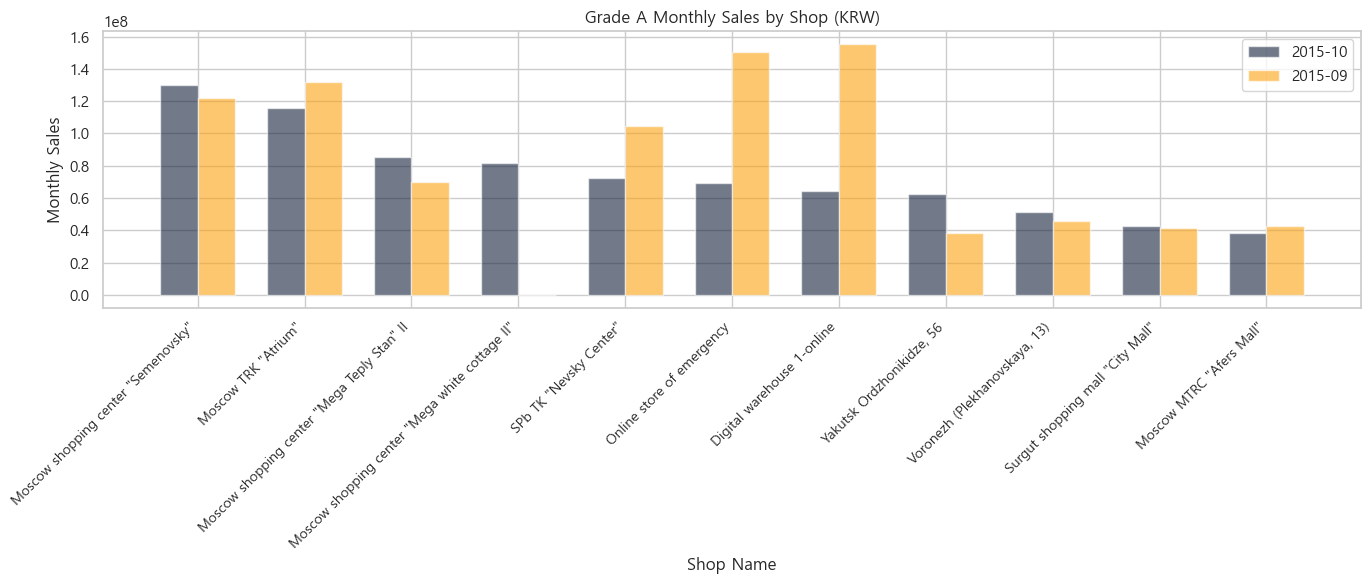

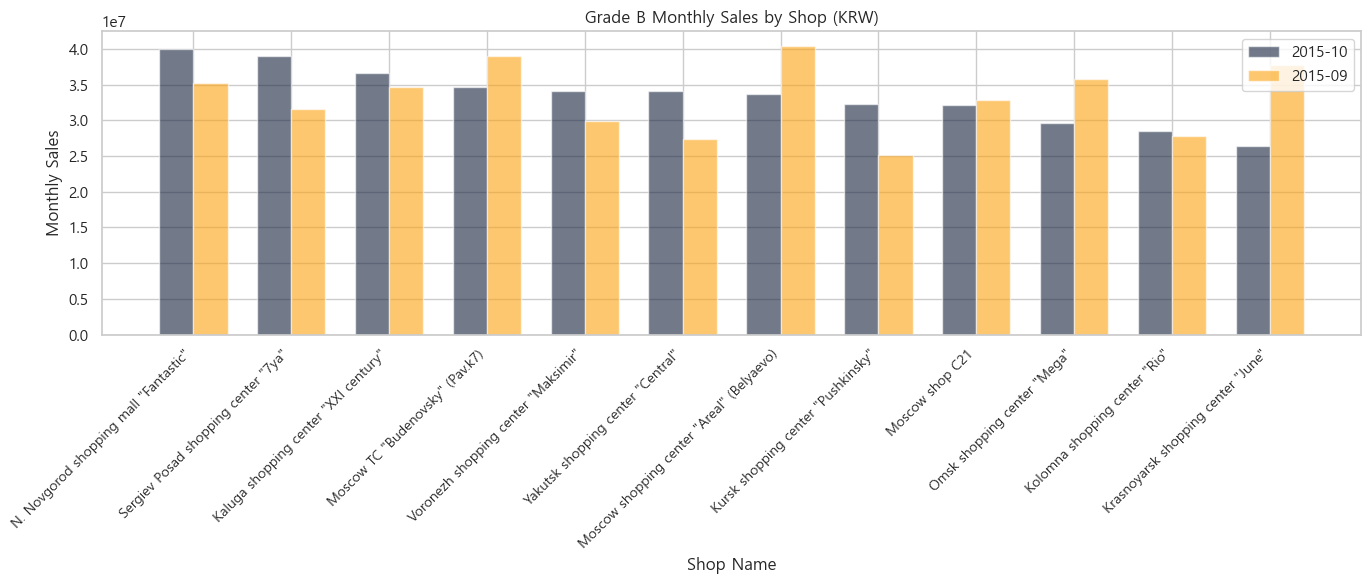

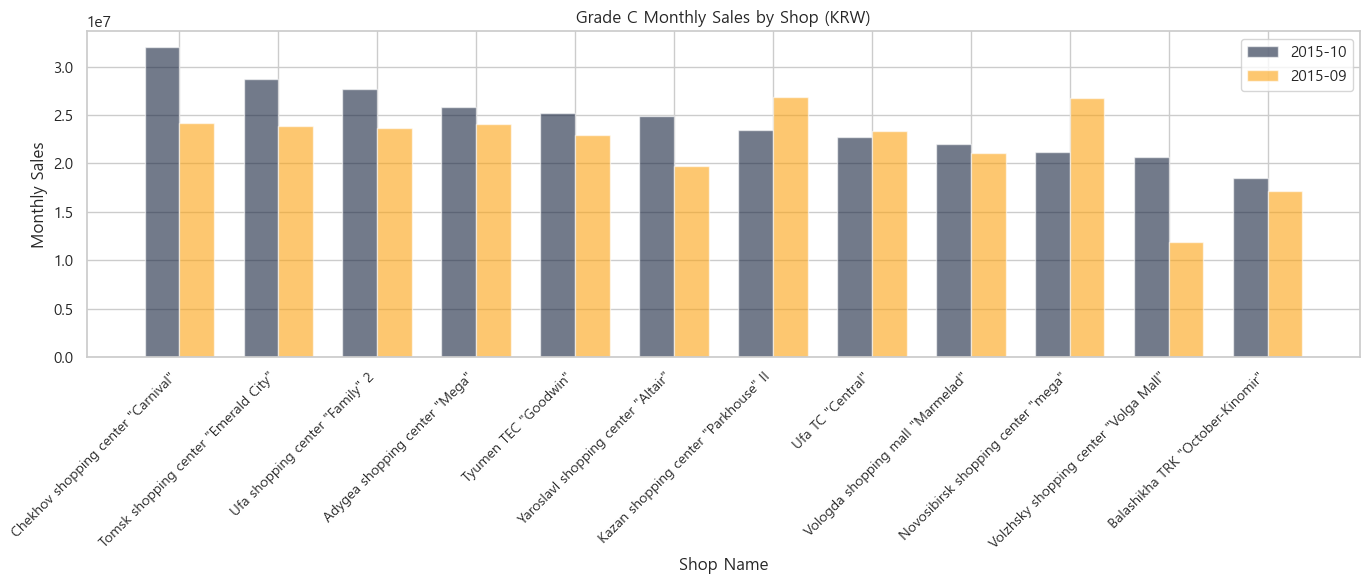

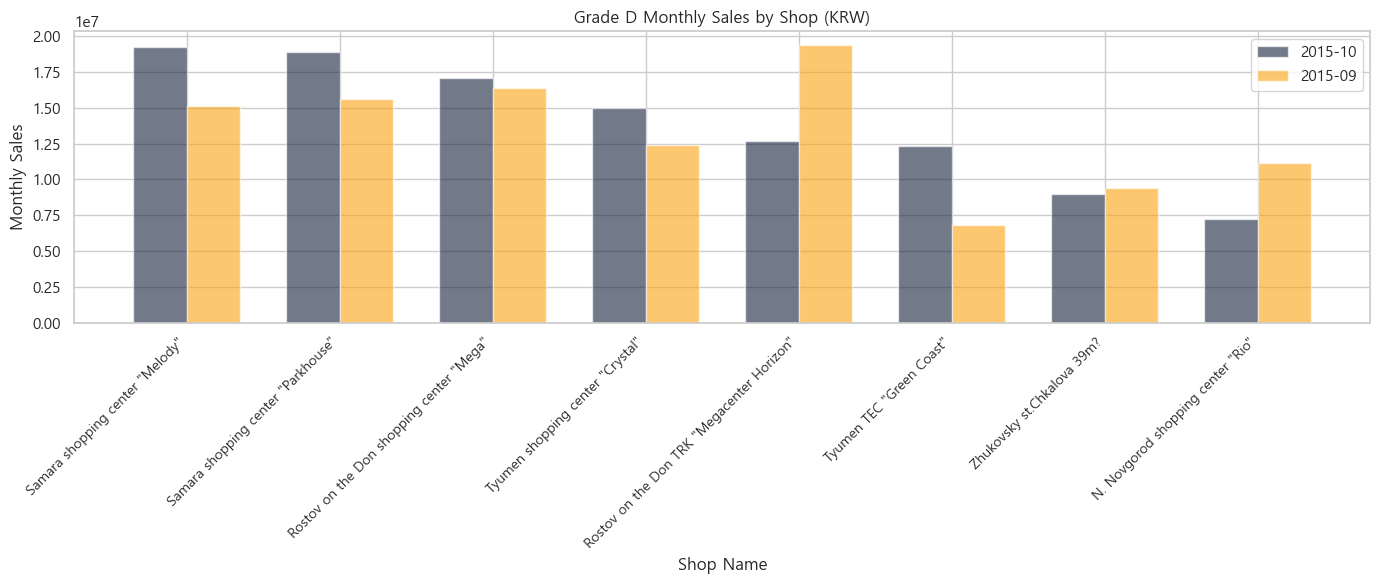

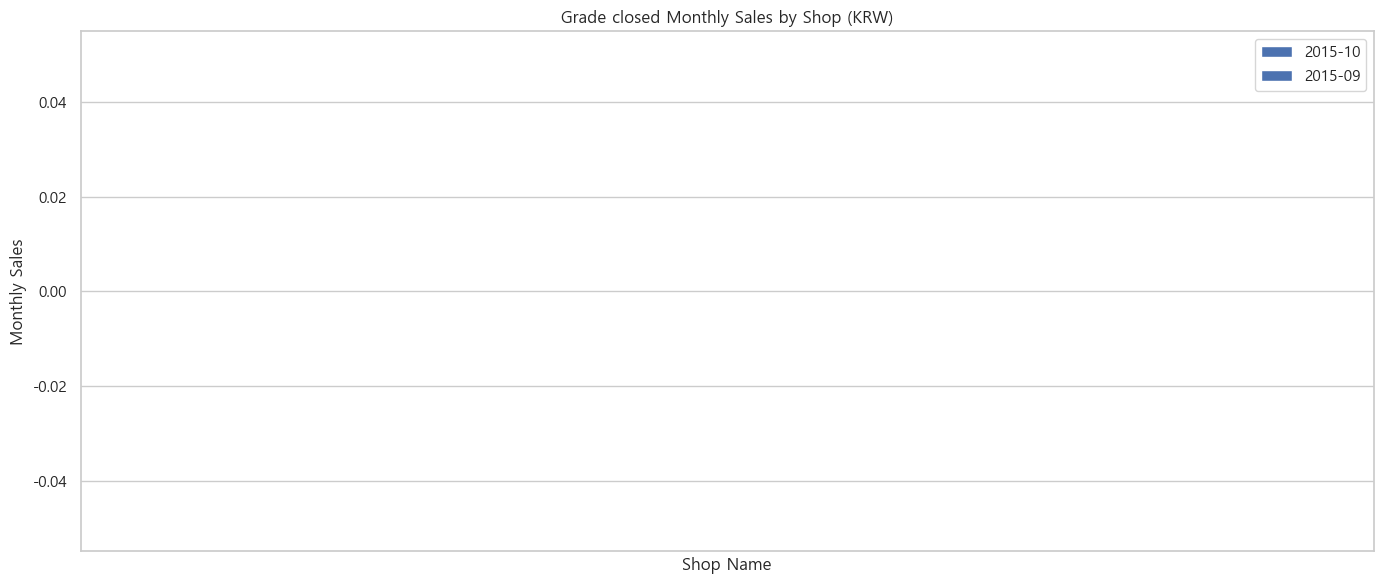

In [39]:
for g in grades:
    # 해당 grade의 데이터 필터링
    this_data = this_grade_monthly_sales[this_grade_monthly_sales['shop_grade'] == g]
    last_data = last_grade_monthly_sales[last_grade_monthly_sales['shop_grade'] == g]

    # 매장별 총 판매량 계산
    this_store_sales = this_data.groupby('shop_name')['monthly_sales'].sum().reset_index()
    last_store_sales = last_data.groupby('shop_name')['monthly_sales'].sum().reset_index()

    # 판매량 기준 내림차순 정렬
    this_store_sales = this_store_sales.sort_values(by='monthly_sales', ascending=False)
    last_store_sales = last_store_sales.sort_values(by='monthly_sales', ascending=False)

    # 공통 매장 기준으로 병합 (둘 다 존재하는 매장만 사용)
    merged = pd.merge(this_store_sales, last_store_sales, on='shop_name', suffixes=('_this', '_last'))
    merged = merged.head(14)  # top 14만 시각화

    fig, ax = plt.subplots(figsize=(14, 6))
    bar_width = 0.35
    index = np.arange(len(merged))

    plt.bar(index, merged['monthly_sales_this'], bar_width,
            alpha=0.6, color='#14213d', label='2015-10')
    plt.bar(index + bar_width, merged['monthly_sales_last'], bar_width,
            alpha=0.6, color='#fca311', label='2015-09')

    plt.xticks(index + bar_width / 2, merged['shop_name'], rotation=45, ha='right', fontsize=10)
    plt.title(f'Grade {g} Monthly Sales by Shop (KRW)')
    plt.xlabel('Shop Name')
    plt.ylabel('Monthly Sales')
    plt.legend()
    plt.tight_layout()
    plt.show()


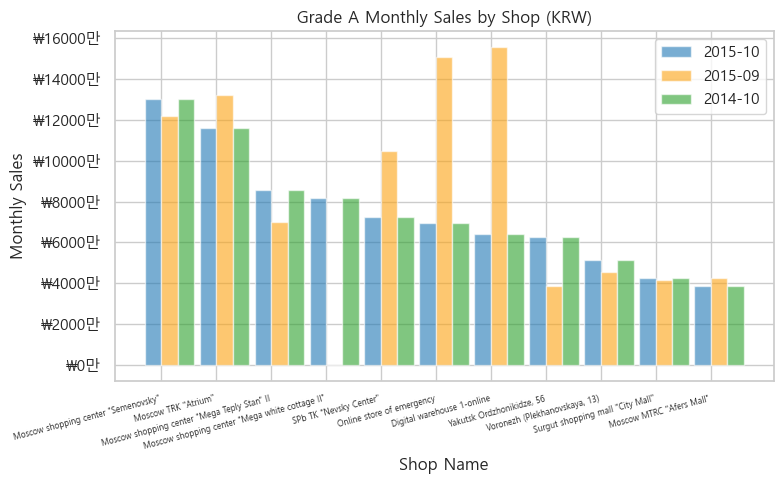

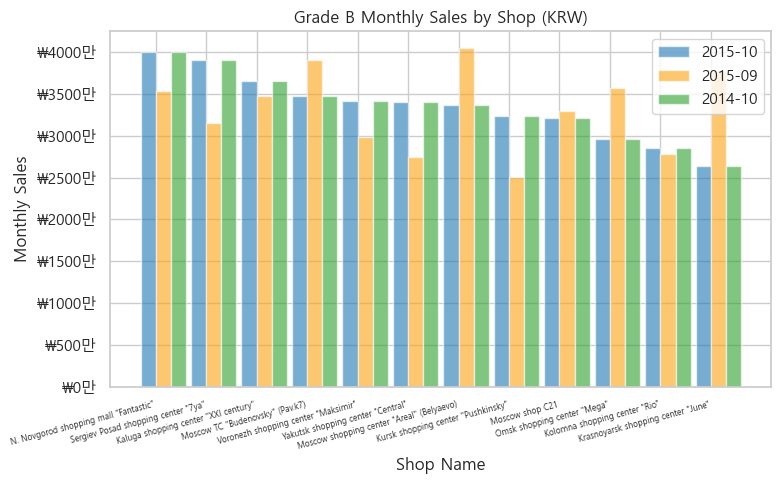

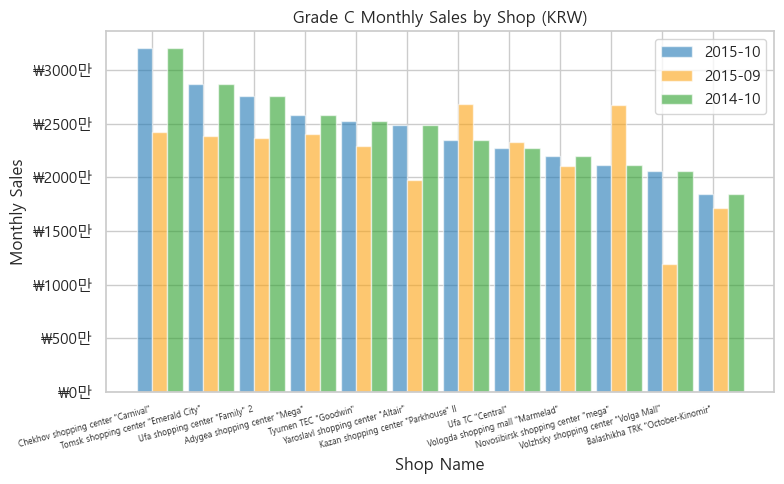

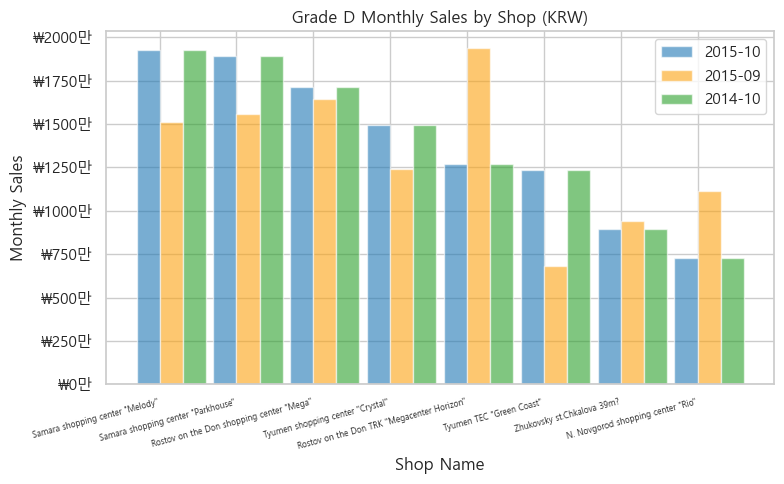

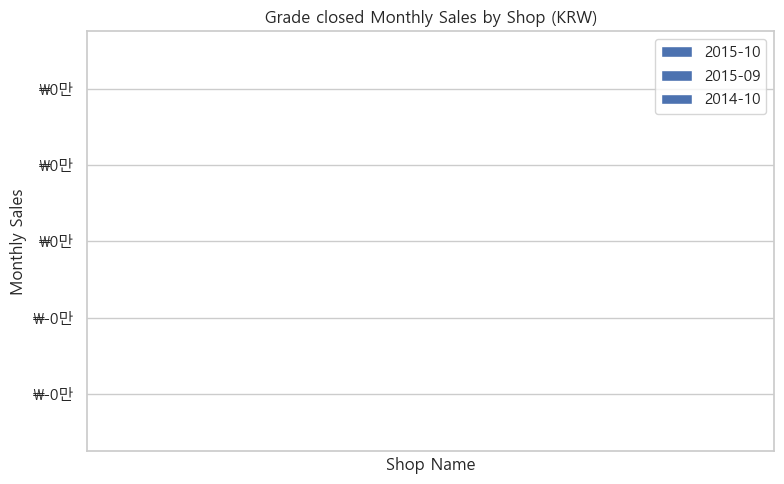

In [40]:
# 천만원 원 단위 포맷터
def format_to_1k(x, pos):
    return f'₩{x * 1e-4:.0f}만'  # M for 만원 단위로 간주

plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", 
rc={"axes.unicode_minus":False}, style='whitegrid')

for g in grades:
    # 해당 grade의 데이터 필터링
    this_data = this_grade_monthly_sales[this_grade_monthly_sales['shop_grade'] == g]
    last_data = last_grade_monthly_sales[last_grade_monthly_sales['shop_grade'] == g]
    year_data = year_grade_monthly_sales[year_grade_monthly_sales['shop_grade'] == g]

    # 매장별 총 판매량 계산
    this_store_sales = this_data.groupby('shop_name')['monthly_sales'].sum().reset_index()
    last_store_sales = last_data.groupby('shop_name')['monthly_sales'].sum().reset_index()
    year_store_sales = year_data.groupby('shop_name')['monthly_sales'].sum().reset_index()

    # 판매량 기준 내림차순 정렬
    this_store_sales = this_store_sales.sort_values(by='monthly_sales', ascending=False)
    last_store_sales = last_store_sales.sort_values(by='monthly_sales', ascending=False)
    year_store_sales = year_store_sales.sort_values(by='monthly_sales', ascending=False)

    # 공통 매장 기준으로 병합 (둘 다 존재하는 매장만 사용)
    year_store_sales = year_store_sales.rename(columns={'monthly_sales': 'monthly_sales_year'})
    merged = pd.merge(this_store_sales, last_store_sales, on='shop_name', suffixes=('_this', '_last'))
    merged = pd.merge(merged, year_store_sales, on='shop_name')
    merged = merged.head(14)  # top 14만 시각화

    fig, ax = plt.subplots(figsize=(8, 5))
    bar_width = 0.3
    index = np.arange(len(merged))

    plt.bar(index, merged['monthly_sales_this'], bar_width, alpha=0.6, color='#1f77b4', label='2015-10')
    plt.bar(index + bar_width, merged['monthly_sales_last'], bar_width, alpha=0.6, color='#fca311', label='2015-09')
    plt.bar(index + 2 * bar_width, merged['monthly_sales_year'], bar_width, alpha=0.6, color='#2ca02c', label='2014-10')

    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_to_1k))
    plt.xticks(index + bar_width/2, merged['shop_name'], rotation=15, ha='right', fontsize=6)
    plt.title(f'Grade {g} Monthly Sales by Shop (KRW)')
    plt.xlabel('Shop Name')
    plt.ylabel('Monthly Sales')
    plt.legend(loc=0)
    plt.tight_layout()
    plt.show()


### 2015년 11월 예측 시각화

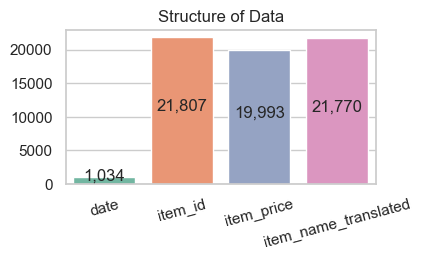

In [41]:
data = {'date': len(df_train.date.unique()),
        'item_id': len(df_train.item_id.unique()),
        'item_price': len(df_train.item_price.unique()),
        'item_name_translated': len(df_train.item_name_translated.unique())}
data_structure = pd.DataFrame(data, index=[0])

sns.set_style('whitegrid')
fig, ax = plt.subplots( figsize=(4,2) )
ax = sns.barplot(data = data_structure, palette = 'Set2')
for p in ax.patches:
    ax.text(p.get_x() + (p.get_width()/2) ,   # 가로 위치
            p.get_y() + p.get_height()/2,   # 세로 위치
            f"{p.get_height():,.0f}",   # 값 + 표시방법 소수 둘째자리까지 
            ha = 'center' )   # 좌우정렬 중간으로
plt.title('Structure of Data')
plt.xticks(rotation=15)
plt.show()

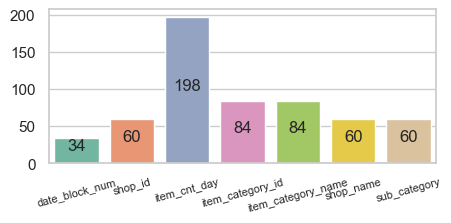

In [42]:
data = {'date_block_num': len(df_train.date_block_num.unique()),
        'shop_id': len(df_train.shop_id.unique()),
        'item_cnt_day': len(df_train.item_cnt_day.unique()),
        'item_category_id': len(df_train.item_category_id.unique()),
        'item_category_name': len(df_train.item_category_name.unique()),
        'shop_name': len(df_train.shop_name.unique()),
        'sub_category': len(df_train.shop_id.unique())}
data_structure = pd.DataFrame(data, index=[0])
sns.set_style('whitegrid')
fig, ax = plt.subplots( figsize=(5,2) )
ax = sns.barplot(data = data_structure, palette = 'Set2')
for p in ax.patches:
    ax.text(p.get_x() + (p.get_width()/2) ,   # 가로 위치
            p.get_y() + p.get_height()/2,   # 세로 위치
            f"{p.get_height():,.0f}",   # 값 + 표시방법 소수 둘째자리까지 
            ha = 'center' )   # 좌우정렬 중간으로
plt.xticks(rotation=15, fontsize=8)
plt.show()

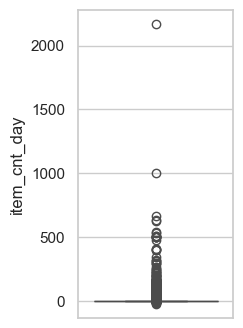

In [43]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots( figsize=(2,4) )
sns.boxplot(y='item_cnt_day', data=df_train)
plt.show()

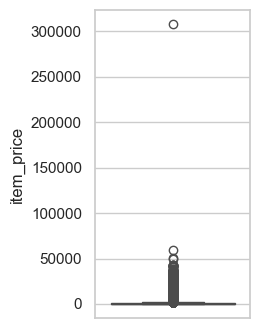

In [44]:
fig, ax = plt.subplots( figsize=(2,4) )
sns.boxplot(y='item_price', data=df_train);
plt.show()

In [45]:
pd.set_option('display.max_columns', None)
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name_translated,item_category_id,item_category_name,shop_name,shop_grade,holiday,weekend,city,sub_category,rub_amount,krw_amount,year,month,day,year_month
0,2013-01-02,0,59,22154,999.00,1.0,SCENE 2012 (BD),37,Cinema - Blu -Ray,"Yaroslavl shopping center ""Altair""",C,1,0,Yaroslavl,Cinema,999.00,17982.0,2013,1,2,2013-01
1,2013-01-03,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Music - vinyl,"Moscow TRK ""Atrium""",A,1,0,Moscow,Music,899.00,16182.0,2013,1,3,2013-01
2,2013-01-05,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Music - vinyl,"Moscow TRK ""Atrium""",A,0,1,Moscow,Music,-899.00,-16182.0,2013,1,5,2013-01
3,2013-01-06,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Music - vinyl,"Moscow TRK ""Atrium""",A,0,1,Moscow,Music,1709.05,30762.9,2013,1,6,2013-01
4,2013-01-15,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Ð¤Ð¸?Ð¼.),56,Music - CD of corporate production,"Moscow TRK ""Atrium""",A,0,0,Moscow,Music,1099.00,19782.0,2013,1,15,2013-01


In [46]:
df_pred = pd.read_excel('./predict_sales_filled_3.xlsx', engine='openpyxl')

In [47]:
# item_id별로 마지막 판매 일자를 기준으로 가장 마지막 가격 추출
last_prices = (
    df_train.sort_values(['item_id', 'date'])  # 먼저 날짜순으로 정렬
      .groupby('item_id')                # item_id 기준 그룹화
      .last()                            # 각 그룹에서 마지막 행 추출
      .reset_index()[['item_id', 'item_price']]  # 필요한 컬럼만
)

# item_id 리스트 생성
item_price_list = df_train['item_id'].unique()

# item_id와 마지막 가격을 묶은 DataFrame 생성
item_price_df = pd.DataFrame({'item_id': item_price_list})

# 마지막 가격 정보 결합
item_price_df = item_price_df.merge(last_prices, on='item_id', how='left')

# 결과 확인
print(item_price_df.head())

   item_id  item_price
0    22154      299.00
1     2552      949.00
2     2554     1709.05
3     2555     1149.00
4     2564      249.00


In [48]:
df_train_2 = df_train.copy()

In [49]:
df_train_2 = pd.concat([df_train_2, df_pred])

In [50]:
# category, shop 중분류 추가
df_train_2['city'] = df_train_2['shop_name'].str.split(' ').str[0]
df_train_2['sub_category'] = df_train_2['item_category_name'].str.split(' ').str[0]
# 중분류명 정리 → 13개
df_train_2['sub_category'] = df_train_2['sub_category'].replace({'Pure' : 'Carrier', 'Clean' : 'Carrier', 'Elements': 'Batteries', 'Payment' : 'Gift Card', 'Service' : 'Tickets', 'Android' : 'Games', 'Mac' : 'Games', 'Game' : 'Games'})
# city명 정리
df_train_2['city'] = df_train_2['city'].replace({'!' : 'Yakutsk', 'Exit' : 'Other', 'N.' : 'NizhnyNovgorod', 'SPb' : 'SanktPetersburg', 'Digital' : 'Online'})

In [51]:
df_train_2.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name_translated,item_category_id,item_category_name,shop_name,shop_grade,holiday,weekend,city,sub_category,rub_amount,krw_amount,year,month,day,year_month
238167,2015-11-01,34,59,22162,349.00,0.115440,NaN,40,Cinema - DVD,"Yaroslavl shopping center ""Altair""",NaN,NaN,NaN,Yaroslavl,Cinema,40.288463,725.192333,2015,11,1,2015-11-01 00:00:00
238168,2015-11-01,34,59,22163,90.23,0.123268,NaN,40,Cinema - DVD,"Yaroslavl shopping center ""Altair""",NaN,NaN,NaN,Yaroslavl,Cinema,11.122490,200.204828,2015,11,1,2015-11-01 00:00:00
238169,2015-11-01,34,59,22164,549.00,0.150644,NaN,37,Cinema - Blu -Ray,"Yaroslavl shopping center ""Altair""",NaN,NaN,NaN,Yaroslavl,Cinema,82.703659,1488.665856,2015,11,1,2015-11-01 00:00:00
238170,2015-11-01,34,59,22166,150.00,-0.023599,NaN,54,Books are a figure,"Yaroslavl shopping center ""Altair""",NaN,NaN,NaN,Yaroslavl,Books,-3.539905,-63.718282,2015,11,1,2015-11-01 00:00:00
238171,2015-11-01,34,59,22167,299.00,0.071352,NaN,49,Books - Methodological materials 1C,"Yaroslavl shopping center ""Altair""",NaN,NaN,NaN,Yaroslavl,Books,21.334184,384.015315,2015,11,1,2015-11-01 00:00:00


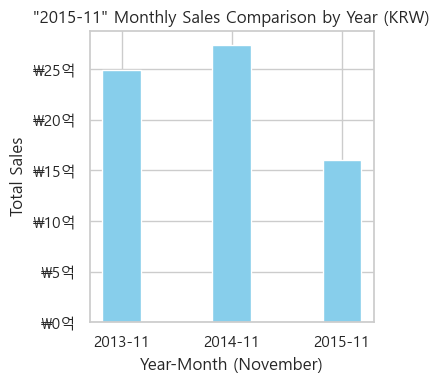

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# 비교할 연도 11월 데이터 필터링
compare_years = ['2013-11', '2014-11', '2015-11']
df_train_2['year_month'] = df_train_2['date'].dt.to_period('M')
annual_sales = df_train_2[df_train_2['year_month'].astype(str).isin(compare_years)]

# 연도별 매출 합계 계산
annual_summary = annual_sales.groupby('year_month')['krw_amount'].sum().sort_index()
annual_summary_reset = pd.DataFrame(annual_summary).reset_index()
index = range(len(annual_summary_reset))

plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", 
rc={"axes.unicode_minus":False}, style='whitegrid')

# 스타일 설정
# sns.set_style('whitegrid')
plt.figure(figsize=(4,4))

# 데이터 재정렬 및 인덱스 생성
bar_width = 0.35
index = range(len(annual_summary_reset))
# 억 원 단위 포맷터
def format_to_100m(x, pos):
    return f'₩{x * 1e-8:.0f}억'  # B for "Billion KRW" (억 단위로 간주)

# 한화 매출 막대
plt.bar(index, annual_summary_reset['krw_amount'], bar_width, label='KRW Amount', color='skyblue')

# x축 라벨 설정 (2013-11, 2014-11, 2015-11)
plt.xticks(index, annual_summary_reset['year_month'])
plt.xlabel('Year-Month (November)')
plt.ylabel('Total Sales')
plt.title('"2015-11" Monthly Sales Comparison by Year (KRW)')
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_to_100m))
# plt.legend()

plt.tight_layout()
plt.show()

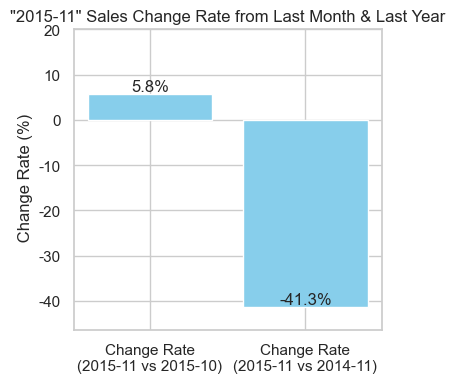

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# 각 비교별 % 변화율 계산 (루블, 한화 합계 기준)
# rub_amount와 krw_amount 합친 총 매출 기준으로 할 수도 있지만, 여기서는 krw_amount 기준으로 예시 작성

compare_months = ['2015-11', '2015-10', '2014-11']
monthly_sales = df_train_2[df_train_2['year_month'].astype(str).isin(compare_months)]
monthly_summary = monthly_sales.groupby('year_month')[['rub_amount', 'krw_amount']].sum().sort_index()
month_rate = (monthly_summary.loc['2015-11', 'krw_amount'] / monthly_summary.loc['2015-10', 'krw_amount'] - 1) * 100
year_month_rate = (monthly_summary.loc['2015-11', 'krw_amount'] / monthly_summary.loc['2014-11', 'krw_amount'] - 1) * 100

# 데이터 프레임 생성
rates = pd.Series([ month_rate, year_month_rate],
                  index=['Change Rate\n(2015-11 vs 2015-10)', 'Change Rate\n(2015-11 vs 2014-11)'])

plt.figure(figsize=(4,4))
bars = plt.bar(rates.index, rates.values, color='skyblue')

plt.ylabel(' Change Rate (%)')
plt.title('"2015-11" Sales Change Rate from Last Month & Last Year') # Rub이나 KRW이나 비율은 같음
plt.ylim(min(rates.values.min() - 5, -20), max(rates.values.max() + 5, 20))

# 막대 위에 값 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.1f}%',
             ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

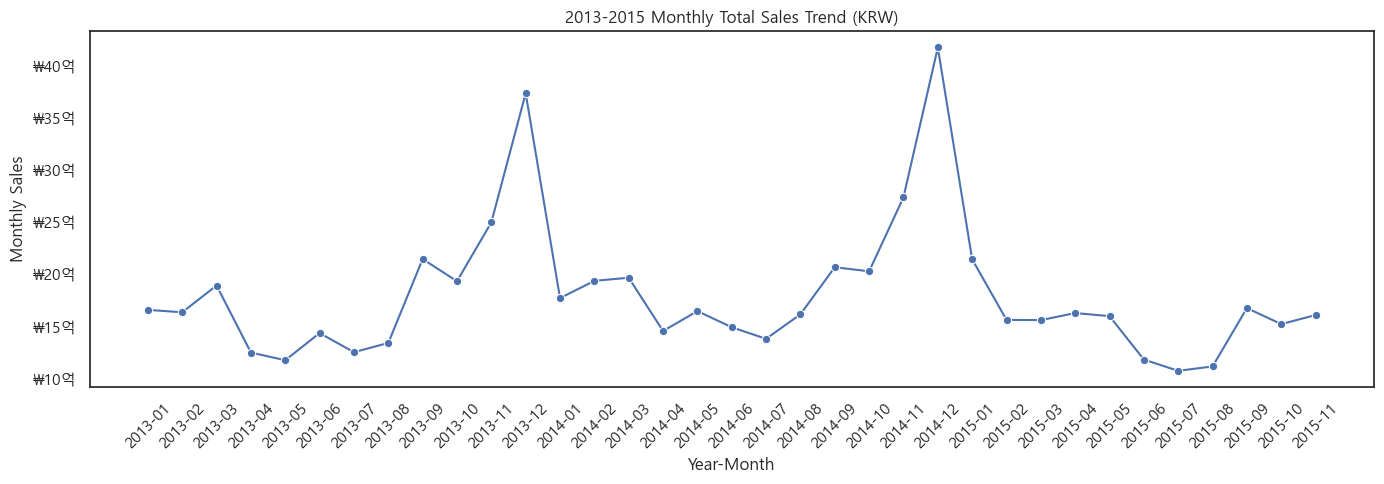

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", 
rc={"axes.unicode_minus":False}, style='white')

# 월별  평균 매출 계산
monthly_sales = df_train_2.groupby('year_month')['krw_amount'].sum()
monthly_sales = pd.DataFrame(monthly_sales).reset_index()

plt.figure(figsize=(14, 5))
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_to_100m))
sns.set_style('whitegrid')
sns.lineplot(data=monthly_sales, x= monthly_sales['year_month'].astype(str), y='krw_amount', palette='Blues_d', marker = 'o')

plt.title('2013-2015 Monthly Total Sales Trend (KRW)')
plt.xlabel('Year-Month')
plt.ylabel('Monthly Sales')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

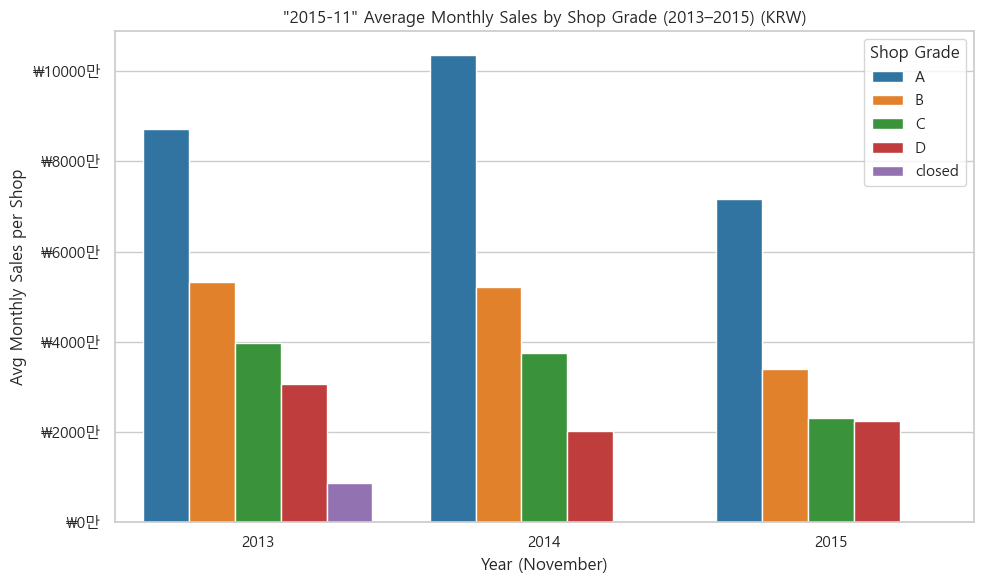

📊 2015년 11월 평균 *월간 판매량* 및 전년 동월 대비 증감률

[등급 A]
- 평균 월간 판매량 (2015년 11월): 71,579,130
- 2014년 대비 증감률: -30.9%
- 2013년 대비 증감률: -18.0%

[등급 B]
- 평균 월간 판매량 (2015년 11월): 33,980,463
- 2014년 대비 증감률: -34.8%
- 2013년 대비 증감률: -36.2%

[등급 C]
- 평균 월간 판매량 (2015년 11월): 23,086,598
- 2014년 대비 증감률: -38.6%
- 2013년 대비 증감률: -41.9%

[등급 D]
- 평균 월간 판매량 (2015년 11월): 22,551,553
- 2014년 대비 증감률: +11.2%
- 2013년 대비 증감률: -26.4%

[등급 closed]
- 평균 월간 판매량 (2015년 11월): nan
- 2014년 대비 증감률: nan%
- 2013년 대비 증감률: nan%



In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# # # 1. 날짜 처리
# # df_train_2['date'] = pd.to_datetime(df_train['date'])
# df_train_2['year'] = df_train_2['date'].dt.year
# df_train_2['month'] = df_train_2['date'].dt.month


plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", 
rc={"axes.unicode_minus":False}, style='whitegrid')


# 2. 11월만 필터링
november = df_train_2[df_train_2['month'] == 11]

# 3. 매장별 11월 월간 판매량 계산 (item_cnt_day 합산)
monthly_sales = (
    november
    .groupby(['year', 'shop_id', 'shop_grade'])['krw_amount']
    .sum()
    .reset_index(name='monthly_sales')  # 한 매장의 11월 총 판매량
)

# 4. 연도별, 등급별 평균 매장당 월간 판매량
november_grouped = (
    monthly_sales
    .groupby(['year', 'shop_grade'])['monthly_sales']
    .mean()
    .reset_index(name='avg_sales')
)

# 5. 피벗하여 증감률 계산
nov_pivot = november_grouped.pivot(index='shop_grade', columns='year', values='avg_sales').reset_index()
nov_pivot['2015_vs_2013'] = ((nov_pivot[2015] - nov_pivot[2013]) / nov_pivot[2013] * 100).round(1)
nov_pivot['2015_vs_2014'] = ((nov_pivot[2015] - nov_pivot[2014]) / nov_pivot[2014] * 100).round(1)

# 6. 시각화용 long-form 데이터 생성
plot_df = pd.melt(
    nov_pivot,
    id_vars='shop_grade',
    value_vars=[2013, 2014, 2015],
    var_name='year',
    value_name='avg_sales'
)

# 7. 등급 순서와 색상 정의
grade_order = ['A', 'B', 'C', 'D', 'closed']
palette = {'A': '#1f77b4', 'B': '#ff7f0e', 'C': '#2ca02c', 'D': '#d62728', 'closed': '#9467bd'}

# 8. 시각화
plt.figure(figsize=(10, 6))
# sns.set_style('whitegrid')
sns.barplot(
    data=plot_df,
    x='year',
    y='avg_sales',
    hue='shop_grade',
    palette=palette,
    hue_order=grade_order
)

# 천만원 원 단위 포맷터
def format_to_1k(x, pos):
    return f'₩{x * 1e-4:.0f}만'  # M for 만원 단위로 간주

plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", 
rc={"axes.unicode_minus":False}, style='whitegrid')

plt.title('"2015-11" Average Monthly Sales by Shop Grade (2013–2015) (KRW)')
plt.ylabel('Avg Monthly Sales per Shop')
plt.xlabel('Year (November)')
plt.legend(title='Shop Grade')
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_to_1k))
plt.tight_layout()
plt.show()

# 9. 콘솔 출력
print("📊 2015년 11월 평균 *월간 판매량* 및 전년 동월 대비 증감률\n")
for i, row in nov_pivot.iterrows():
    grade = row['shop_grade']
    sales_2015 = row[2015]
    change_13 = row['2015_vs_2013']
    change_14 = row['2015_vs_2014']

    print(f"[등급 {grade}]")
    print(f"- 평균 월간 판매량 (2015년 11월): {sales_2015:,.0f}")
    print(f"- 2014년 대비 증감률: {'+' if change_14 >= 0 else ''}{change_14}%")
    print(f"- 2013년 대비 증감률: {'+' if change_13 >= 0 else ''}{change_13}%")
    print()


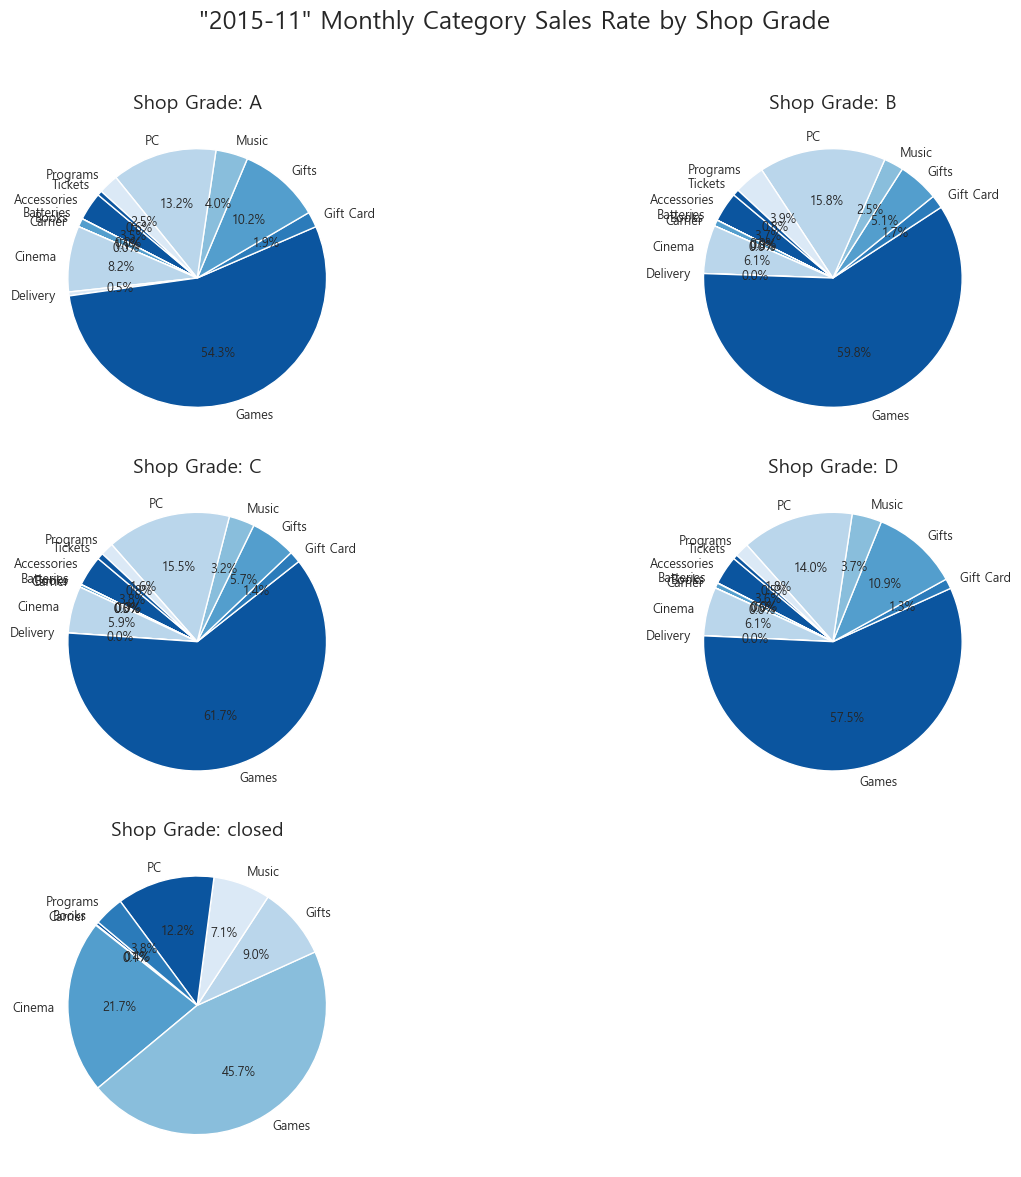

In [56]:
# 1. 날짜 처리
# df_train['year_month'] = df_train['date'].dt.to_period('M').astype(str)

# 2. 11월만 필터링
# november = df_train[df_train['year_month'] == '2015-11']

# 3. 매장별 10월 월간 판매량 계산 (item_cnt_day 합산)
grade_category_monthly_sales = (
    november
    .groupby(['sub_category', 'shop_grade'])['krw_amount']
    .sum()
    .reset_index(name='monthly_sales')  # 한 매장의 11월 총 판매량
)

import math

grades = sorted(grade_category_monthly_sales['shop_grade'].unique())
n_grades = len(grades)

# 행, 열 개수 계산 (예: 최대 2열, 행은 필요한 만큼)
n_cols = 2
n_rows = math.ceil(n_grades / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(7 * n_cols, 4 * n_rows))
axes = axes.flatten()  # 1차원 배열로 변환

# colors = sns.color_palette('BuPu_r',len(grade_category_monthly_sales['sub_category'])) ## 라벨의 개수 만큼 색상 리스트 생성 
colors = sns.color_palette('Blues_r') 

for i, grade in enumerate(grades):
    data = grade_category_monthly_sales[grade_category_monthly_sales['shop_grade'] == grade]
    data = data[data['monthly_sales'] > 0]
    sales = data['monthly_sales']
    categories = data['sub_category']

    axes[i].pie(
        sales,
        labels=categories,
        autopct='%1.1f%%',
        startangle=140,
        textprops={'fontsize': 9},
        colors = colors  
    )
    axes[i].set_title(f'Shop Grade: {grade}', fontsize=14)

# 남는 subplot은 삭제
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('"2015-11" Monthly Category Sales Rate by Shop Grade', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


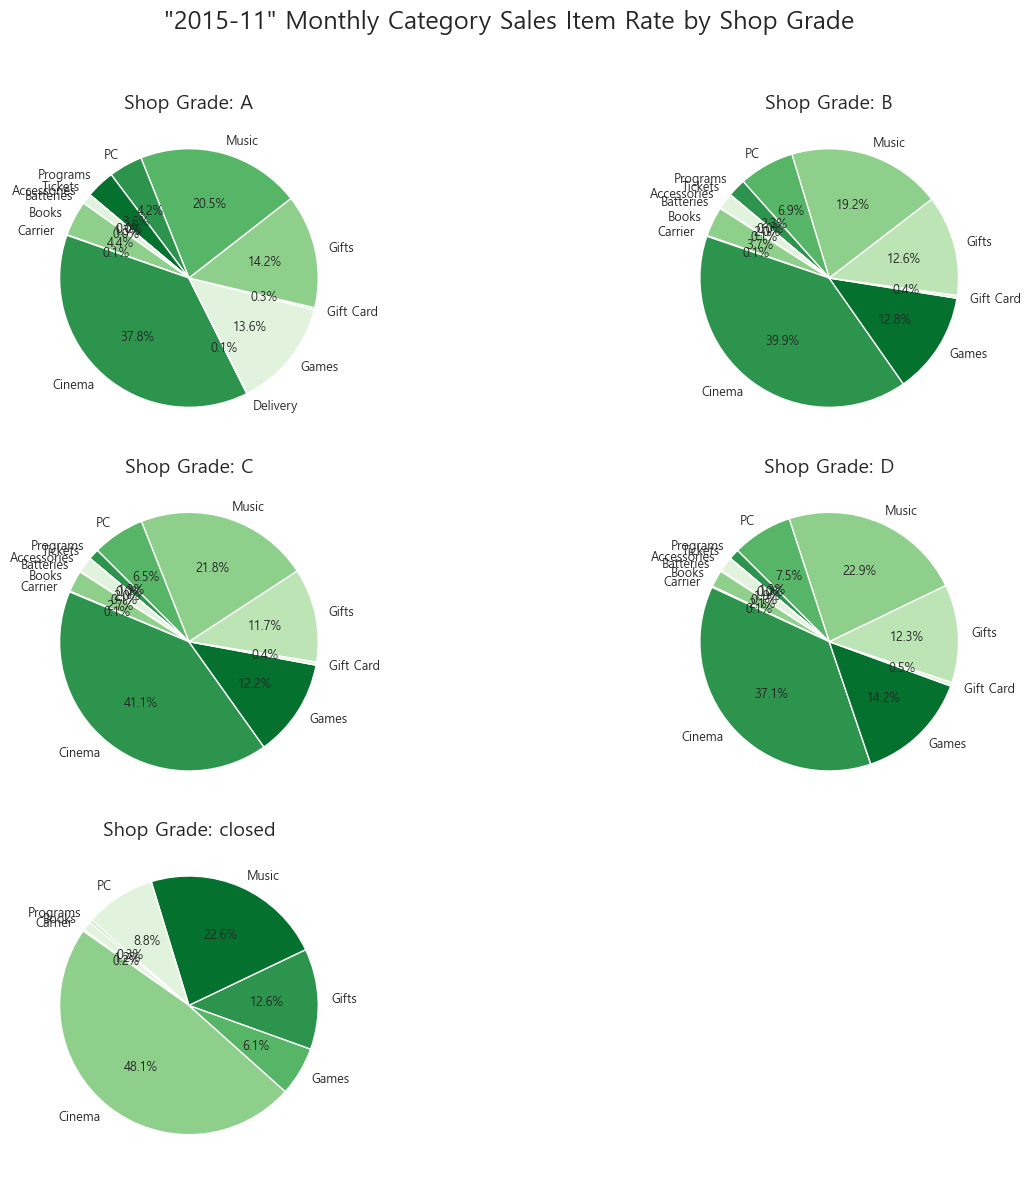

In [57]:
# 1. 날짜 처리
# df_train['year_month'] = df_train['date'].dt.to_period('M').astype(str)

# 2. 11월만 필터링
# november = df_train[df_train['year_month'] == '2015-11']

# 3. 매장별 11월 월간 판매량 계산 (item_cnt_day 합산)
grade_category_monthly_sales = (
    november
    .groupby(['sub_category', 'shop_grade'])['item_name_translated']
    .nunique()
    .reset_index(name='monthly_sales')
)

import math

grades = sorted(grade_category_monthly_sales['shop_grade'].unique())
n_grades = len(grades)

# 행, 열 개수 계산 (예: 최대 2열, 행은 필요한 만큼)
n_cols = 2
n_rows = math.ceil(n_grades / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(7 * n_cols, 4 * n_rows))
axes = axes.flatten()  # 1차원 배열로 변환

# colors = sns.color_palette('BuPu_r',len(grade_category_monthly_sales['sub_category'])) ## 라벨의 개수 만큼 색상 리스트 생성 
colors = sns.color_palette('Greens') ## 라벨의 개수 만큼 색상 리스트 생성 

for i, grade in enumerate(grades):
    data = grade_category_monthly_sales[grade_category_monthly_sales['shop_grade'] == grade]
    data = data[data['monthly_sales'] > 0]
    sales = data['monthly_sales']
    categories = data['sub_category']

    axes[i].pie(
        sales,
        labels=categories,
        autopct='%1.1f%%',
        startangle=140,
        textprops={'fontsize': 9},
        colors = colors  
    )
    axes[i].set_title(f'Shop Grade: {grade}', fontsize=14)

# 남는 subplot은 삭제
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('"2015-11" Monthly Category Sales Item Rate by Shop Grade', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


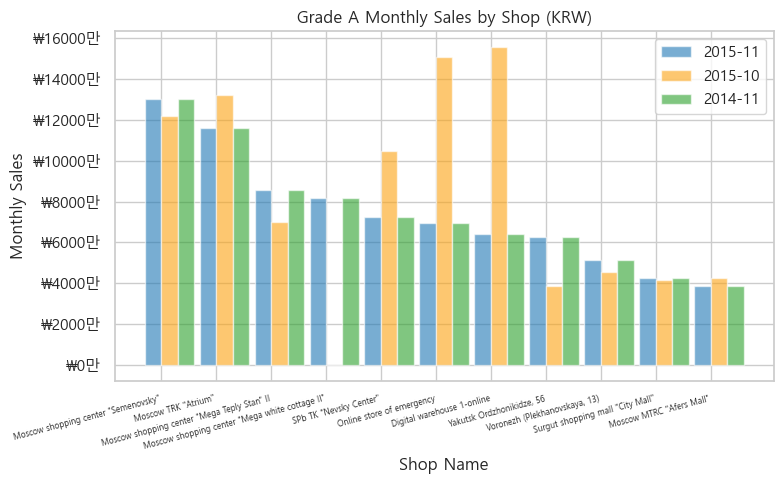

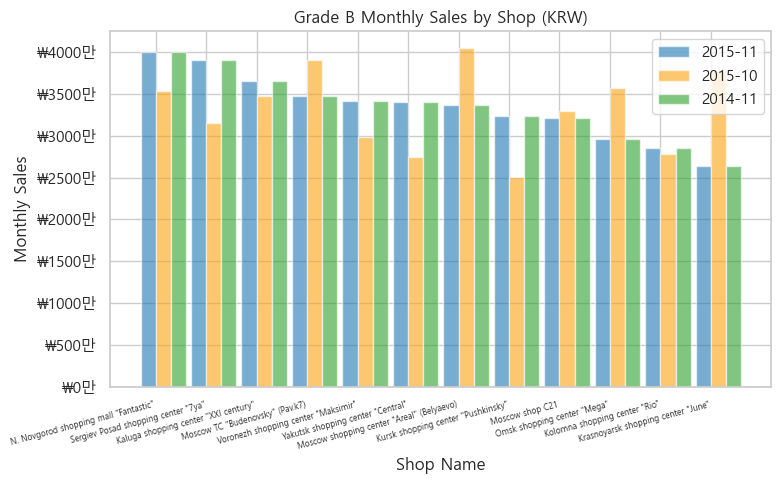

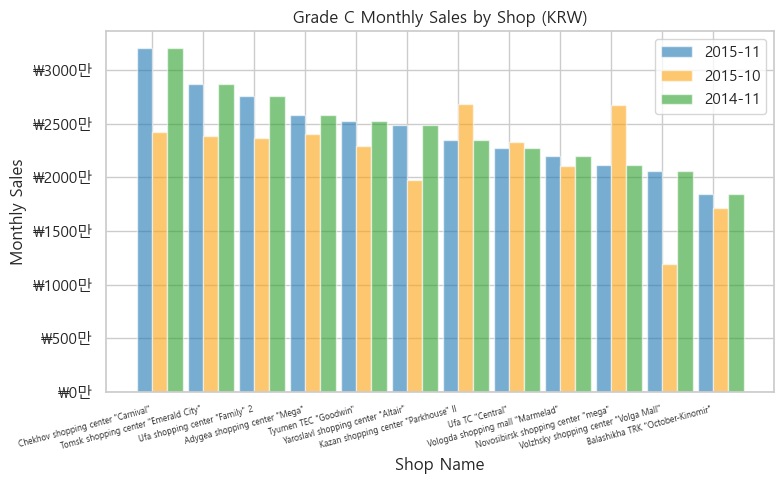

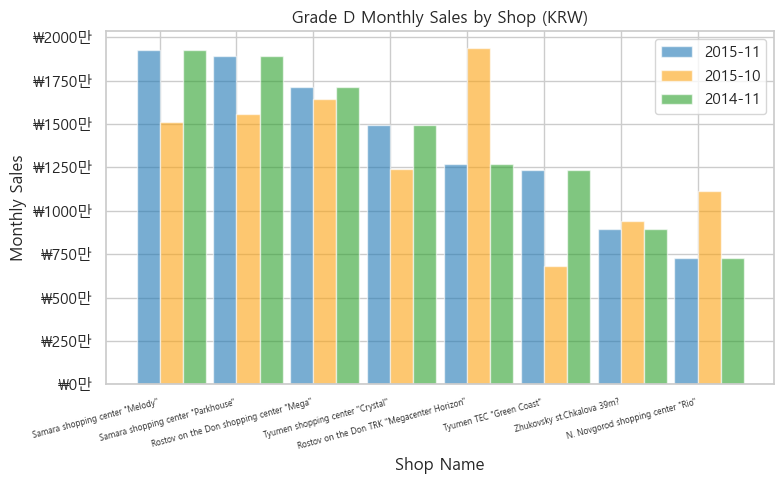

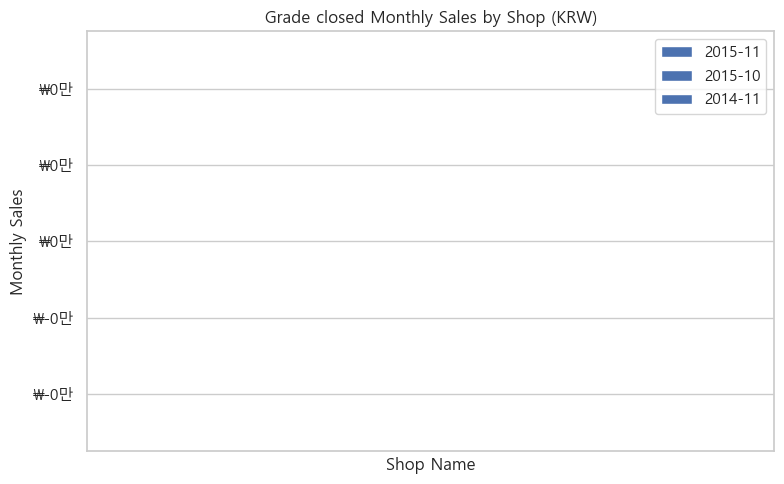

In [58]:
# 천만원 원 단위 포맷터
def format_to_1k(x, pos):
    return f'₩{x * 1e-4:.0f}만'  # M for 만원 단위로 간주

plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", 
rc={"axes.unicode_minus":False}, style='whitegrid')

for g in grades:
    # 해당 grade의 데이터 필터링
    this_data = this_grade_monthly_sales[this_grade_monthly_sales['shop_grade'] == g]
    last_data = last_grade_monthly_sales[last_grade_monthly_sales['shop_grade'] == g]
    year_data = year_grade_monthly_sales[year_grade_monthly_sales['shop_grade'] == g]

    # 매장별 총 판매량 계산
    this_store_sales = this_data.groupby('shop_name')['monthly_sales'].sum().reset_index()
    last_store_sales = last_data.groupby('shop_name')['monthly_sales'].sum().reset_index()
    year_store_sales = year_data.groupby('shop_name')['monthly_sales'].sum().reset_index()

    # 판매량 기준 내림차순 정렬
    this_store_sales = this_store_sales.sort_values(by='monthly_sales', ascending=False)
    last_store_sales = last_store_sales.sort_values(by='monthly_sales', ascending=False)
    year_store_sales = year_store_sales.sort_values(by='monthly_sales', ascending=False)

    # 공통 매장 기준으로 병합 (둘 다 존재하는 매장만 사용)
    year_store_sales = year_store_sales.rename(columns={'monthly_sales': 'monthly_sales_year'})
    merged = pd.merge(this_store_sales, last_store_sales, on='shop_name', suffixes=('_this', '_last'))
    merged = pd.merge(merged, year_store_sales, on='shop_name')
    merged = merged.head(14)  # top 14만 시각화

    fig, ax = plt.subplots(figsize=(8, 5))
    bar_width = 0.3
    index = np.arange(len(merged))

    plt.bar(index, merged['monthly_sales_this'], bar_width, alpha=0.6, color='#1f77b4', label='2015-11')
    plt.bar(index + bar_width, merged['monthly_sales_last'], bar_width, alpha=0.6, color='#fca311', label='2015-10')
    plt.bar(index + 2 * bar_width, merged['monthly_sales_year'], bar_width, alpha=0.6, color='#2ca02c', label='2014-11')

    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_to_1k))
    plt.xticks(index + bar_width/2, merged['shop_name'], rotation=15, ha='right', fontsize=6)
    plt.title(f'Grade {g} Monthly Sales by Shop (KRW)')
    plt.xlabel('Shop Name')
    plt.ylabel('Monthly Sales')
    plt.legend(loc=0)
    plt.tight_layout()
    plt.show()
